# Imports

In [1]:
from dqn_agent import DQNAgent
from ppo_agent import PPOAgent
from ffnn_agent import FFNNAgent
from data_processing import preprocess_all_data, load_preprocessed_dataset, get_activity, get_column_units, get_xy_from_data
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(f"Is CUDA available? {torch.cuda.is_available()}")

Is CUDA available? True


# Load Data

In [2]:
# Load the preprocessed dataset
df = load_preprocessed_dataset()
target_features = ["Resting HR", "Max HR", "Age", "Weight", "Height"]

# Print unique values of target features
for feature in target_features:
    print(f"'{feature}' unique values: {df[feature].unique()}")

# Print unique values of 'Age'
print(f"\nUnique values of 'Age': {df['Age'].unique()}")

# Print how many rows there are for Activity ID 1 and 2
activity_counts = df['Activity ID'].value_counts()
print("\nActivity ID counts:")
for act_id in [1, 2]:
    count = activity_counts.get(act_id, 0)
    print(f"Activity ID {act_id}: {count} rows")

# Split based on Activity ID
df_val = df[df['Activity ID'] == 1].copy()
df_test = df[df['Activity ID'] == 2].copy()
df_train = df[~df['Activity ID'].isin([1, 2])].copy()

# Shuffle train set (optional but recommended)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

# Report split sizes
print(f"\nTrain samples (excluding Activity 1 & 2): {df_train.shape[0]}")
print(f"Validation samples (Activity 1): {df_val.shape[0]}")
print(f"Test samples (Activity 2): {df_test.shape[0]}")

# Get X and y splits
x_train, y_train = get_xy_from_data(df_train, target_features)
x_val, y_val = get_xy_from_data(df_val, target_features)
x_test, y_test = get_xy_from_data(df_test, target_features)

# Sanity check
print(f"\nX_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {x_test.shape}, y_test: {y_test.shape}")


---- Preprocessed Dataset Info ----
Number of rows: 61000
Number of columns: 39
-----------------------------------
'Resting HR' unique values: [75 74 68 58 70 60]
'Max HR' unique values: [193 195 189 196 194 197]
'Age' unique values: [27 25 31 24 26 23]
'Weight' unique values: [83 78 92 95 73 69 86]
'Height' unique values: [182 169 187 194 180 183 173]

Unique values of 'Age': [27 25 31 24 26 23]

Activity ID counts:
Activity ID 1: 7000 rows
Activity ID 2: 7000 rows

Train samples (excluding Activity 1 & 2): 47000
Validation samples (Activity 1): 7000
Test samples (Activity 2): 7000

X_train: (47000, 34), y_train: (47000, 5)
X_val: (7000, 34), y_val: (7000, 5)
X_test: (7000, 34), y_test: (7000, 5)


# Initialize system

In [3]:
continuous_columns = [
    'Timestamp',  'Hand Sensor - Temperature',
    'Hand Sensor - Accelerometer - X', 'Hand Sensor - Accelerometer - Y',
    'Hand Sensor - Accelerometer - Z', 'Hand Sensor - Gyroscope - X',
    'Hand Sensor - Gyroscope - Y', 'Hand Sensor - Gyroscope - Z',
    'Hand Sensor - Magnetometer - X', 'Hand Sensor - Magnetometer - Y',
    'Hand Sensor - Magnetometer - Z', 'Chest Sensor - Temperature',
    'Chest Sensor - Accelerometer - X', 'Chest Sensor - Accelerometer - Y',
    'Chest Sensor - Accelerometer - Z', 'Chest Sensor - Gyroscope - X',
    'Chest Sensor - Gyroscope - Y', 'Chest Sensor - Gyroscope - Z',
    'Chest Sensor - Magnetometer - X', 'Chest Sensor - Magnetometer - Y',
    'Chest Sensor - Magnetometer - Z', 'Ankle Sensor - Temperature',
    'Ankle Sensor - Accelerometer - X', 'Ankle Sensor - Accelerometer - Y',
    'Ankle Sensor - Accelerometer - Z', 'Ankle Sensor - Gyroscope - X',
    'Ankle Sensor - Gyroscope - Y', 'Ankle Sensor - Gyroscope - Z',
    'Ankle Sensor - Magnetometer - X', 'Ankle Sensor - Magnetometer - Y',
    'Ankle Sensor - Magnetometer - Z'
]

discrete_columns = [
     'Sex - Female', 'Heart Rate', "Resting HR", "Max HR", "Weight", "Height"
]

#discrete action size columns
dqn_config = {
    'state_size': 5,  
    'action_size': len(discrete_columns),  
    'hidden_size': 64,
    'lr': 1e-2,
    'gamma': 0.8,
    'batch_size': 64,
    'memory_size': 10000,
    'epsilon_start': 1.0,
    'epsilon_min': 0.01,
    'epsilon_decay': 0.995
}


#continuous
ppo_config = {
    'state_size': 5,  
    'action_size': len(continuous_columns),   
    'hidden_size': 64,
    'lr': 1e-2,
    'gamma': 0.8,
    'clip_epsilon': 0.2,
    'update_epochs': 10,
    'batch_size': 64,
    'c1': 0.5,
    'c2': 0.01
}
classes = [1, 2, 3, 17, 16, 13, 4, 7, 6]

ffnn_config = {
    'input_size': df.shape[1] - 5,
    'hidden_sizes': [16, 16],
    'output_size': 5,
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 20,
    'type': 'regression',
    'classes': None
}

accuracy_reward_multiplier = 10

synthetic_data_amount = 1000
num_episodes = 100

dqn_agent = DQNAgent(**dqn_config)
ppo_agent = PPOAgent(**ppo_config)
ffnn_agent = FFNNAgent(**ffnn_config)
ffnn_agent_og = FFNNAgent(**ffnn_config)

Using device: cuda
Using device: cuda


# Training


Training FFNN on real data only (no synthetic data)...


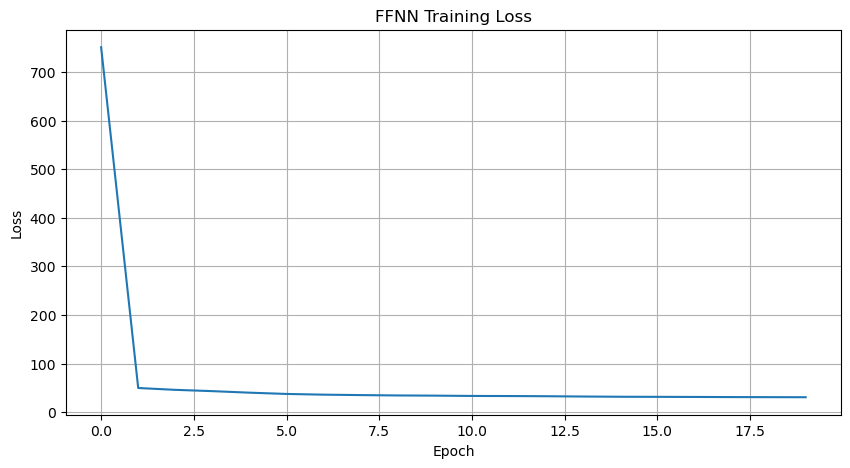


========== FFNN Baseline (No Synthetic Data) ==========
Train MSE: 30.9129 | Train MAE: 4.1300 | Female MSE: 6.1674
Val   MSE: 226.0691 | Val   MAE: 11.3576 | Female MSE: 33.8329
Test  MSE: 51.3987 | Test  MAE: 5.2073 | Female MSE: 10.4091

Episode 1/100: Generating Synthetic Data
Episode 1/100: Training FFNN


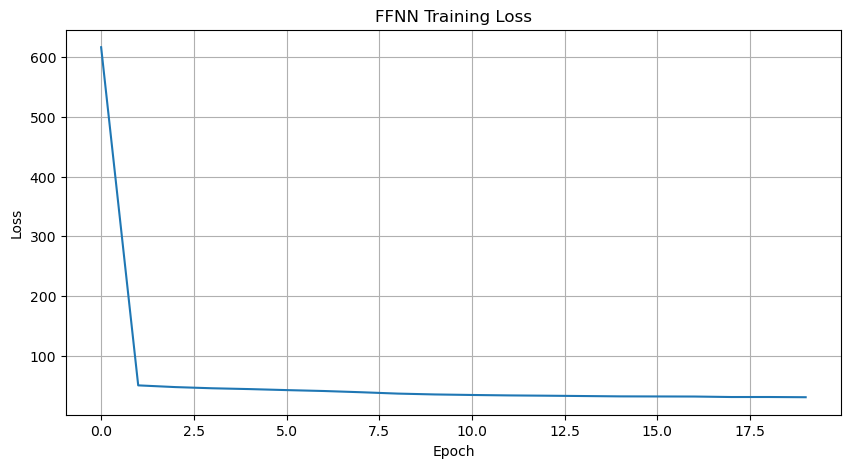

Episode 1/100: Evaluating FFNN
Episode 1/100 | Reward: -1116.1932
Train MSE: 29.4664 | Train Female MSE: 5.9457
Val MSE: 164.7755 | Val Female MSE: 45.8116
Test MSE: 72.7172 | Test Female MSE: 13.2694

--------------------------------

Episode 2/100: Generating Synthetic Data
Episode 2/100: Training FFNN


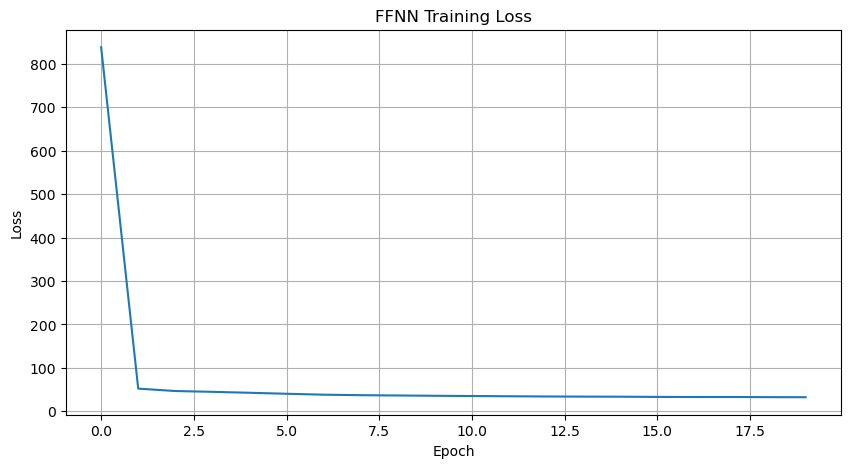

Episode 2/100: Evaluating FFNN
Episode 2/100 | Reward: -1111.2794
Train MSE: 32.1456 | Train Female MSE: 6.7615
Val MSE: 130.1313 | Val Female MSE: 27.8441
Test MSE: 59.1850 | Test Female MSE: 9.6505

--------------------------------

Episode 3/100: Generating Synthetic Data
Episode 3/100: Training FFNN


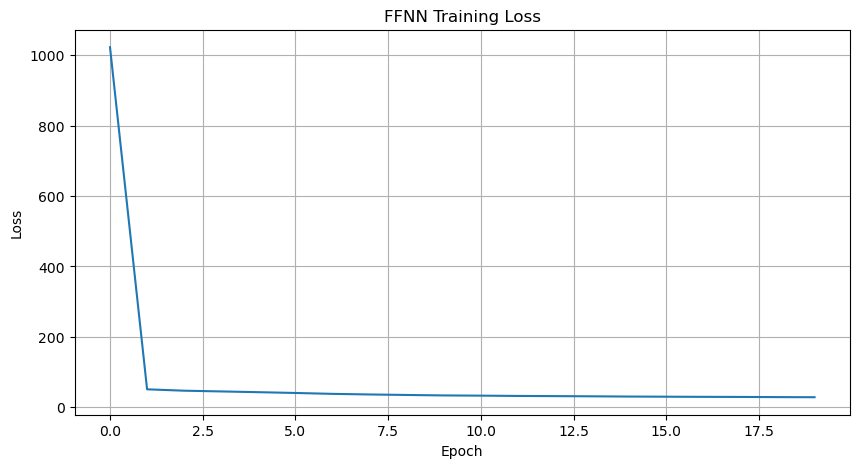

Episode 3/100: Evaluating FFNN
Episode 3/100 | Reward: -587.1645
Train MSE: 28.1967 | Train Female MSE: 6.2901
Val MSE: 97.1295 | Val Female MSE: 34.8457
Test MSE: 47.5210 | Test Female MSE: 8.0695

--------------------------------

Episode 4/100: Generating Synthetic Data
Episode 4/100: Training FFNN


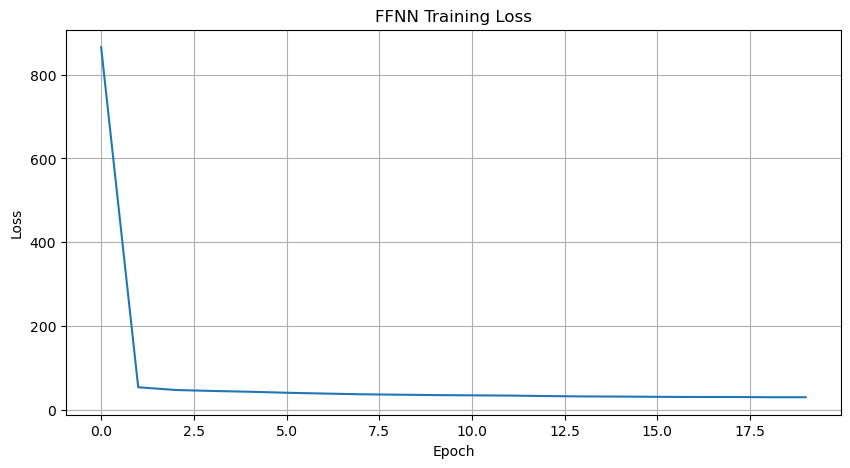

Episode 4/100: Evaluating FFNN
Episode 4/100 | Reward: -298.4674
Train MSE: 29.6583 | Train Female MSE: 6.2497
Val MSE: 112.2876 | Val Female MSE: 33.8004
Test MSE: 60.8659 | Test Female MSE: 14.3125

--------------------------------

Episode 5/100: Generating Synthetic Data
Episode 5/100: Training FFNN


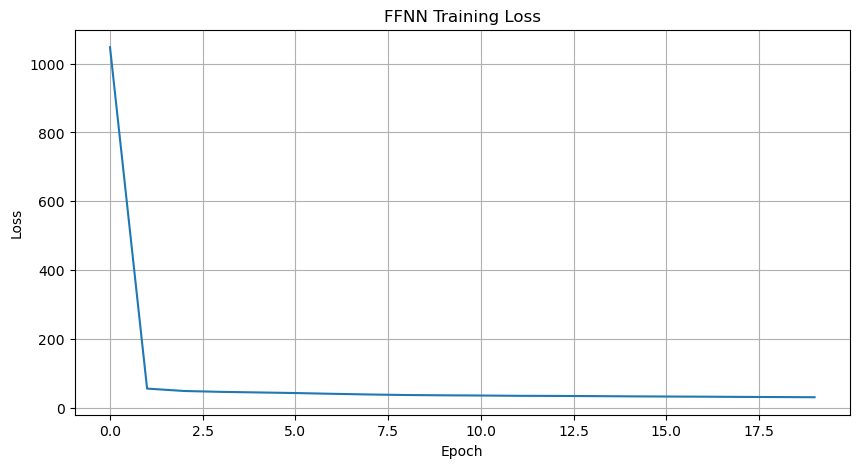

Episode 5/100: Evaluating FFNN
Episode 5/100 | Reward: -1092.8328
Train MSE: 30.6106 | Train Female MSE: 7.1507
Val MSE: 212.3018 | Val Female MSE: 90.5317
Test MSE: 50.9334 | Test Female MSE: 5.2799

--------------------------------

Episode 6/100: Generating Synthetic Data
Episode 6/100: Training FFNN


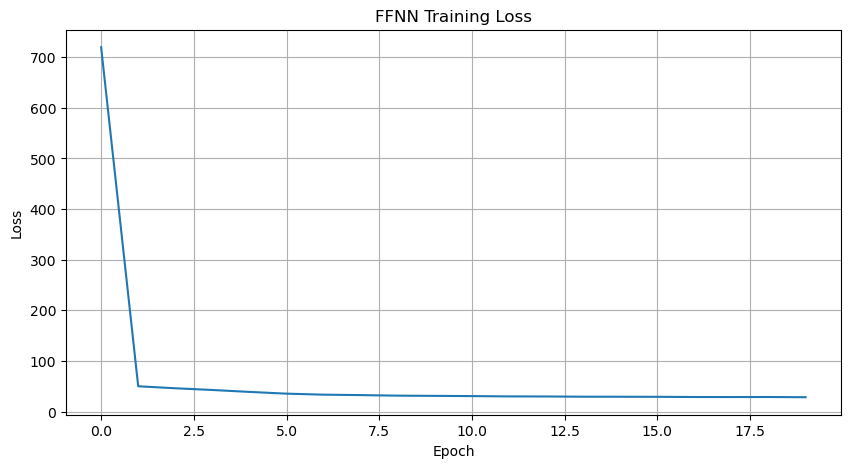

Episode 6/100: Evaluating FFNN
Episode 6/100 | Reward: 331.0537
Train MSE: 28.2212 | Train Female MSE: 7.4790
Val MSE: 125.5153 | Val Female MSE: 35.1662
Test MSE: 75.2892 | Test Female MSE: 28.7956

--------------------------------

Episode 7/100: Generating Synthetic Data
Episode 7/100: Training FFNN


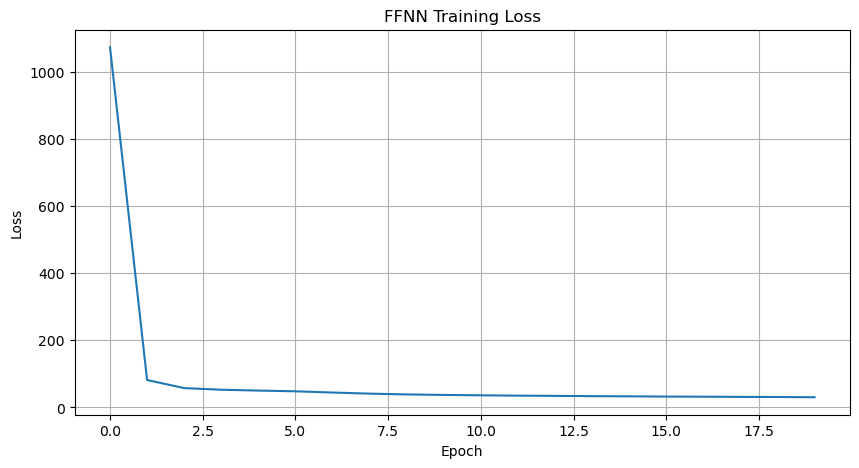

Episode 7/100: Evaluating FFNN
Episode 7/100 | Reward: -165.9539
Train MSE: 30.4380 | Train Female MSE: 5.6211
Val MSE: 155.8283 | Val Female MSE: 74.8917
Test MSE: 64.8471 | Test Female MSE: 4.5984

--------------------------------

Episode 8/100: Generating Synthetic Data
Episode 8/100: Training FFNN


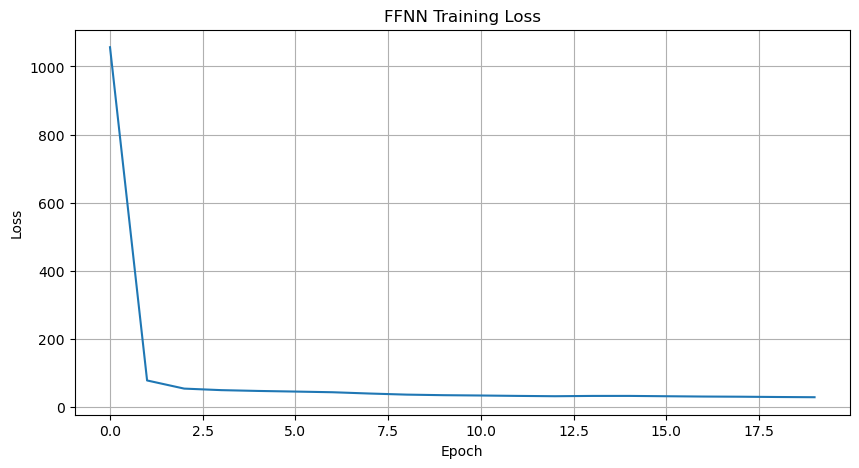

Episode 8/100: Evaluating FFNN
Episode 8/100 | Reward: -15.9505
Train MSE: 30.2260 | Train Female MSE: 7.4963
Val MSE: 146.2263 | Val Female MSE: 56.2480
Test MSE: 70.9236 | Test Female MSE: 26.2891

--------------------------------

Episode 9/100: Generating Synthetic Data
Episode 9/100: Training FFNN


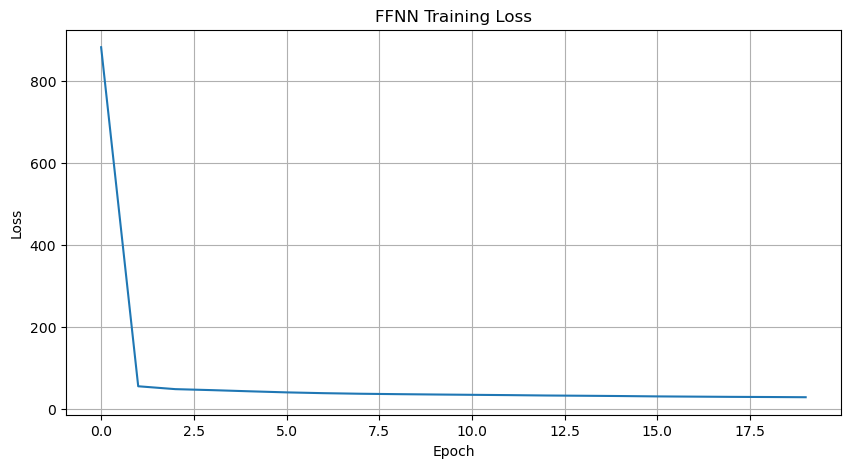

Episode 9/100: Evaluating FFNN
Episode 9/100 | Reward: 742.3489
Train MSE: 27.9194 | Train Female MSE: 6.4724
Val MSE: 199.4712 | Val Female MSE: 51.8372
Test MSE: 62.9244 | Test Female MSE: 10.7033

--------------------------------

Episode 10/100: Generating Synthetic Data
Episode 10/100: Training FFNN


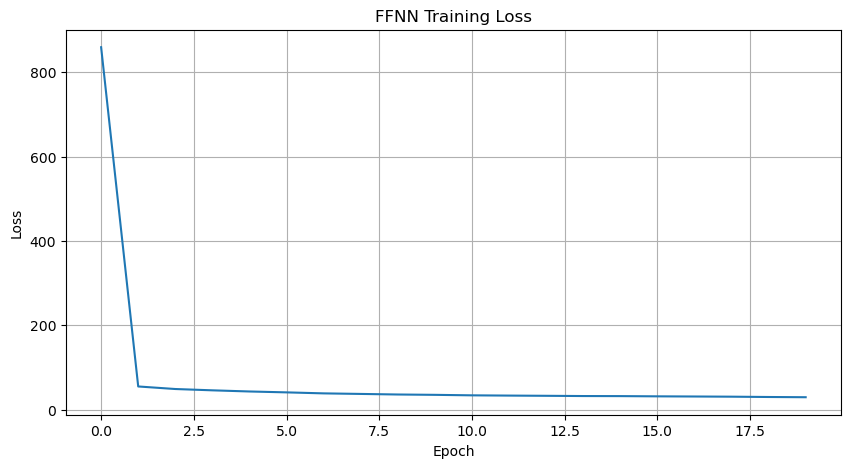

Episode 10/100: Evaluating FFNN
Episode 10/100 | Reward: -491.7574
Train MSE: 31.2853 | Train Female MSE: 9.9444
Val MSE: 144.0350 | Val Female MSE: 27.3954
Test MSE: 51.8436 | Test Female MSE: 5.8706

--------------------------------

Episode 11/100: Generating Synthetic Data
Episode 11/100: Training FFNN


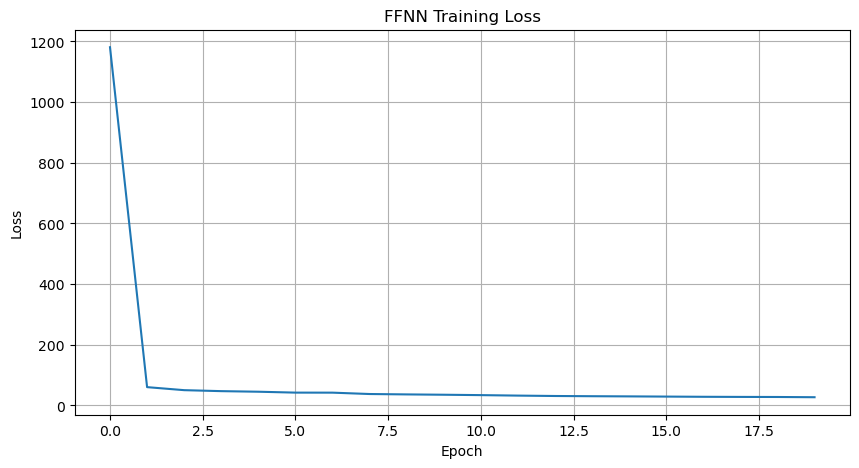

Episode 11/100: Evaluating FFNN
Episode 11/100 | Reward: 1060.1206
Train MSE: 28.5053 | Train Female MSE: 9.0074
Val MSE: 75.4031 | Val Female MSE: 65.3648
Test MSE: 47.0118 | Test Female MSE: 12.7898

--------------------------------

Episode 12/100: Generating Synthetic Data
Episode 12/100: Training FFNN


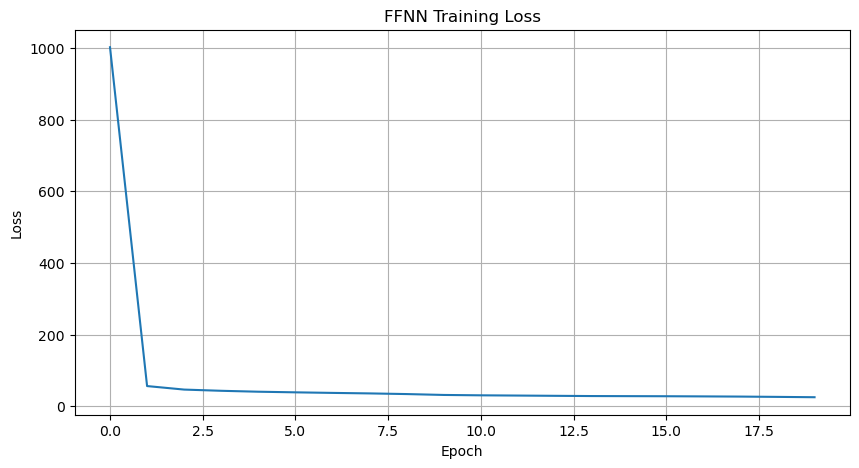

Episode 12/100: Evaluating FFNN
Episode 12/100 | Reward: 1128.2921
Train MSE: 29.3166 | Train Female MSE: 9.2222
Val MSE: 79.8532 | Val Female MSE: 13.0589
Test MSE: 82.6382 | Test Female MSE: 17.9088

--------------------------------

Episode 13/100: Generating Synthetic Data
Episode 13/100: Training FFNN


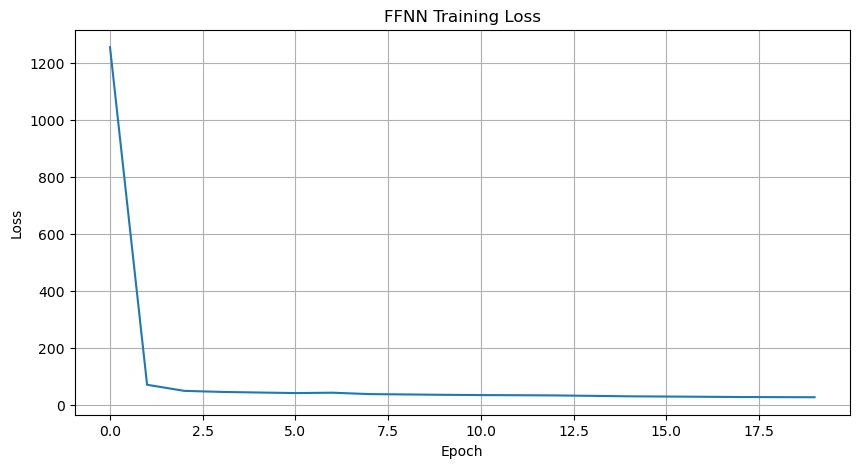

Episode 13/100: Evaluating FFNN
Episode 13/100 | Reward: 2714.7721
Train MSE: 27.1279 | Train Female MSE: 6.3622
Val MSE: 93.6708 | Val Female MSE: 56.2082
Test MSE: 71.1935 | Test Female MSE: 38.4854

--------------------------------

Episode 14/100: Generating Synthetic Data
Episode 14/100: Training FFNN


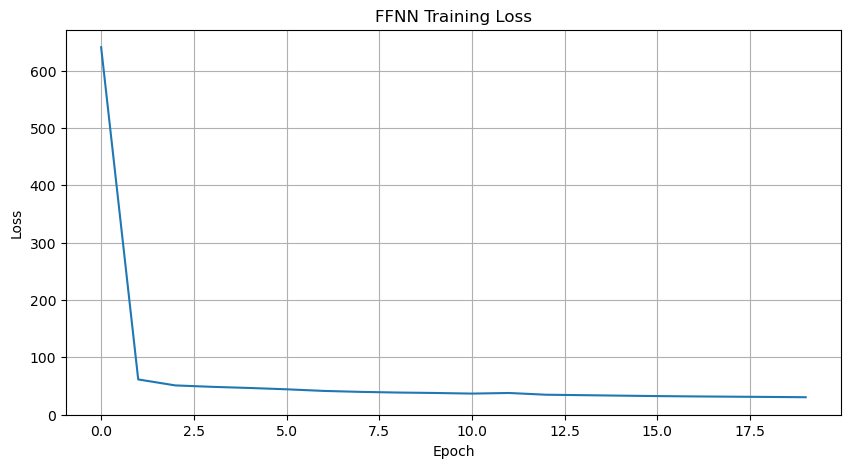

Episode 14/100: Evaluating FFNN
Episode 14/100 | Reward: 2108.4759
Train MSE: 29.8329 | Train Female MSE: 7.8128
Val MSE: 70.4833 | Val Female MSE: 10.7141
Test MSE: 51.5173 | Test Female MSE: 12.4901

--------------------------------

Episode 15/100: Generating Synthetic Data
Episode 15/100: Training FFNN


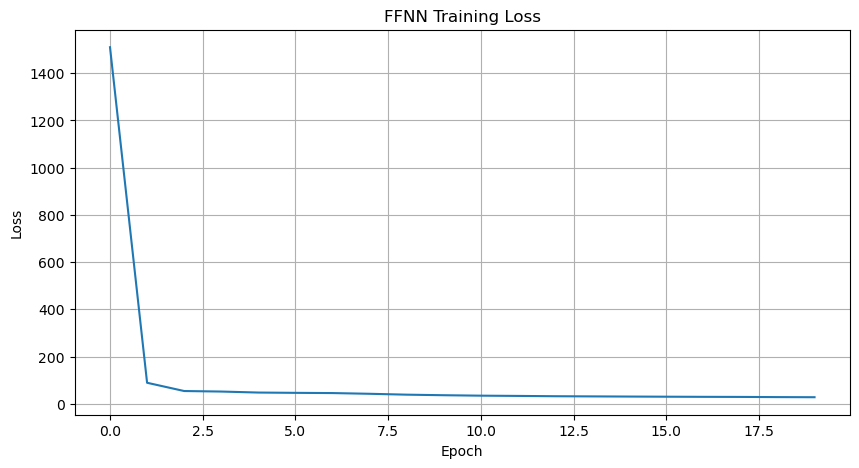

Episode 15/100: Evaluating FFNN
Episode 15/100 | Reward: 2499.2997
Train MSE: 26.0995 | Train Female MSE: 6.6371
Val MSE: 115.2192 | Val Female MSE: 42.2657
Test MSE: 59.2966 | Test Female MSE: 33.0226

--------------------------------

Episode 16/100: Generating Synthetic Data
Episode 16/100: Training FFNN


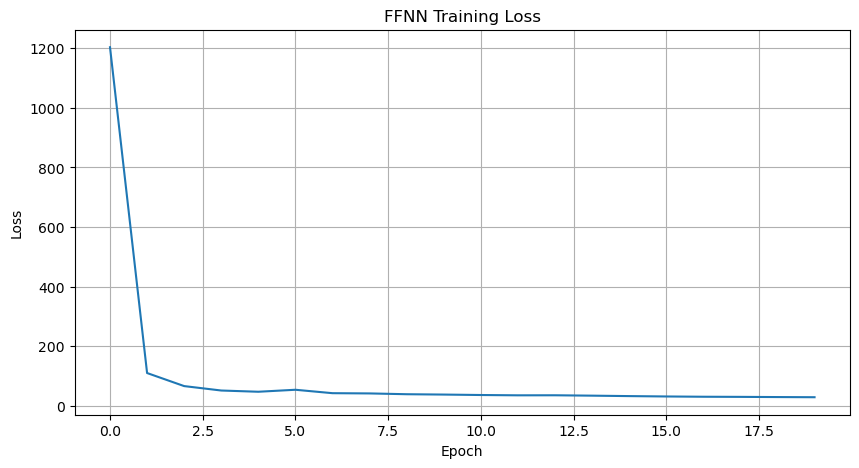

Episode 16/100: Evaluating FFNN
Episode 16/100 | Reward: 2677.4753
Train MSE: 28.5020 | Train Female MSE: 7.1484
Val MSE: 86.8822 | Val Female MSE: 13.5561
Test MSE: 64.7284 | Test Female MSE: 10.6262

--------------------------------

Episode 17/100: Generating Synthetic Data
Episode 17/100: Training FFNN


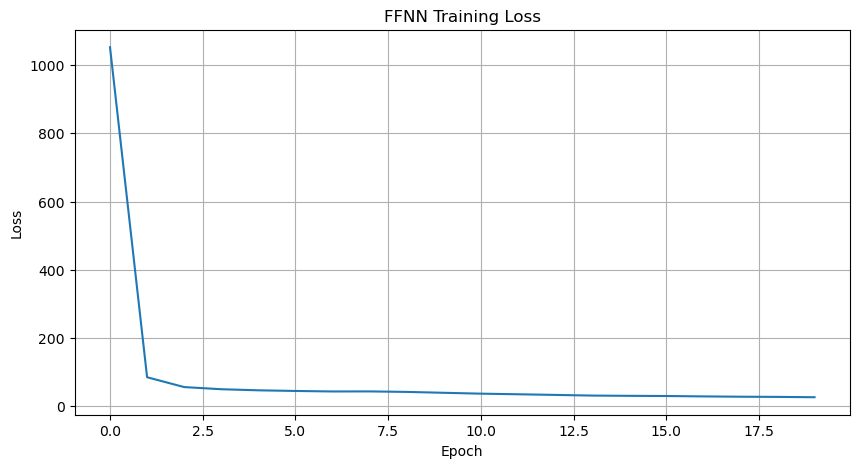

Episode 17/100: Evaluating FFNN
Episode 17/100 | Reward: 1504.1837
Train MSE: 24.7878 | Train Female MSE: 5.4120
Val MSE: 147.3286 | Val Female MSE: 115.5314
Test MSE: 60.5553 | Test Female MSE: 13.4988

--------------------------------

Episode 18/100: Generating Synthetic Data
Episode 18/100: Training FFNN


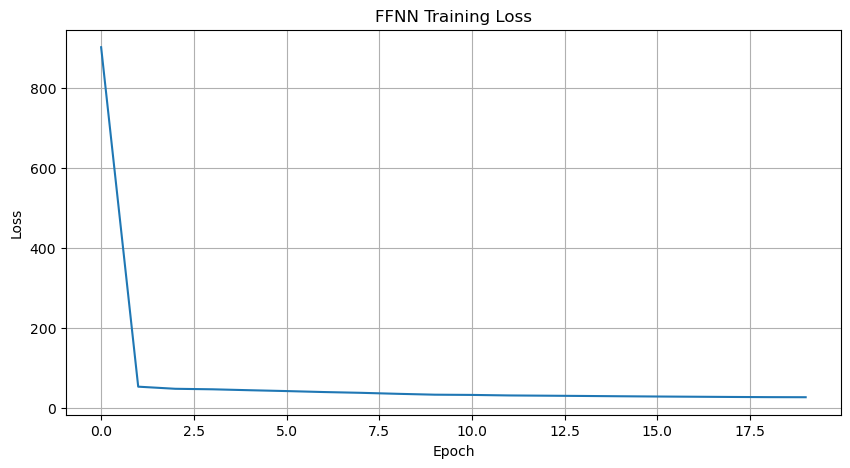

Episode 18/100: Evaluating FFNN
Episode 18/100 | Reward: 635.5159
Train MSE: 28.4263 | Train Female MSE: 9.6052
Val MSE: 106.7722 | Val Female MSE: 53.3681
Test MSE: 75.9467 | Test Female MSE: 12.7350

--------------------------------

Episode 19/100: Generating Synthetic Data
Episode 19/100: Training FFNN


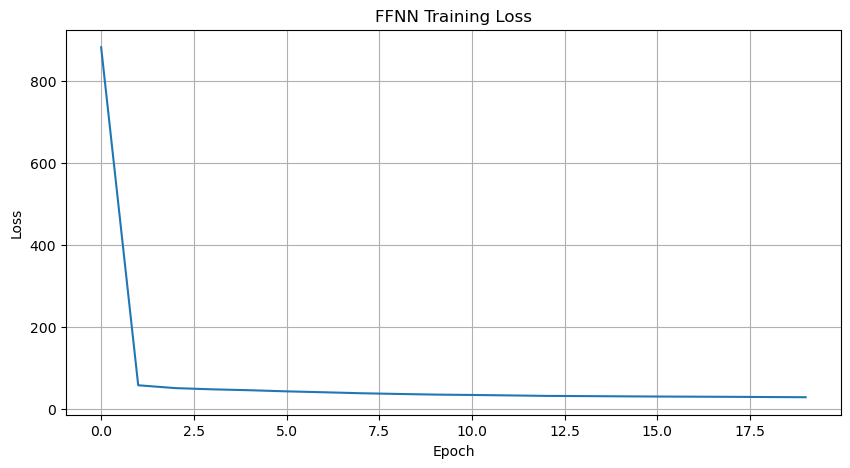

Episode 19/100: Evaluating FFNN
Episode 19/100 | Reward: -27.4590
Train MSE: 27.6073 | Train Female MSE: 7.4239
Val MSE: 79.9968 | Val Female MSE: 31.5990
Test MSE: 49.3056 | Test Female MSE: 9.4550

--------------------------------

Episode 20/100: Generating Synthetic Data
Episode 20/100: Training FFNN


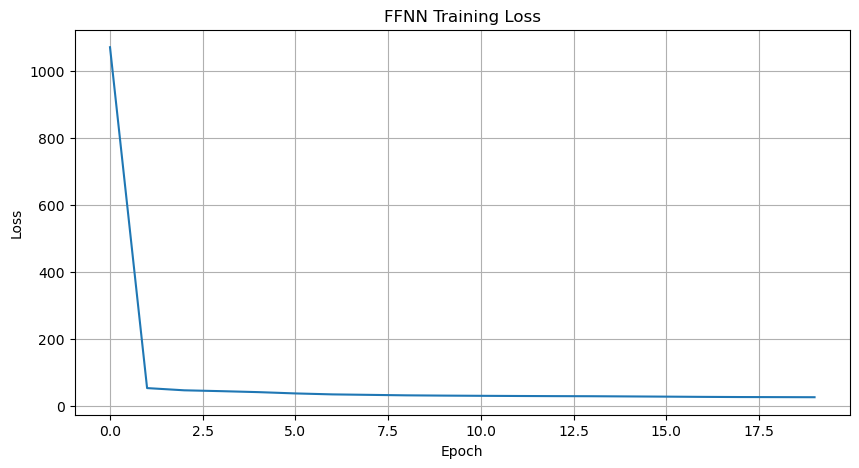

Episode 20/100: Evaluating FFNN
Episode 20/100 | Reward: -433.4739
Train MSE: 26.4510 | Train Female MSE: 4.4695
Val MSE: 168.7130 | Val Female MSE: 11.8239
Test MSE: 41.4895 | Test Female MSE: 4.4896

--------------------------------

Episode 21/100: Generating Synthetic Data
Episode 21/100: Training FFNN


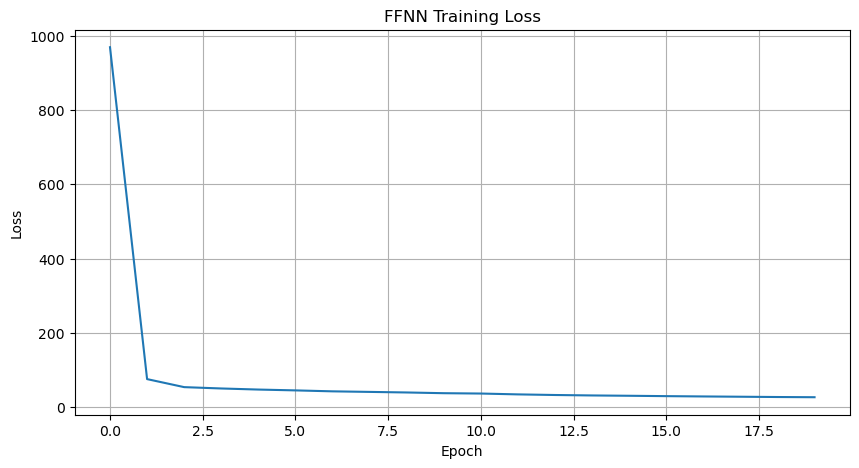

Episode 21/100: Evaluating FFNN
Episode 21/100 | Reward: 653.7688
Train MSE: 27.3860 | Train Female MSE: 8.1747
Val MSE: 77.3911 | Val Female MSE: 5.0434
Test MSE: 66.0131 | Test Female MSE: 4.9070

--------------------------------

Episode 22/100: Generating Synthetic Data
Episode 22/100: Training FFNN


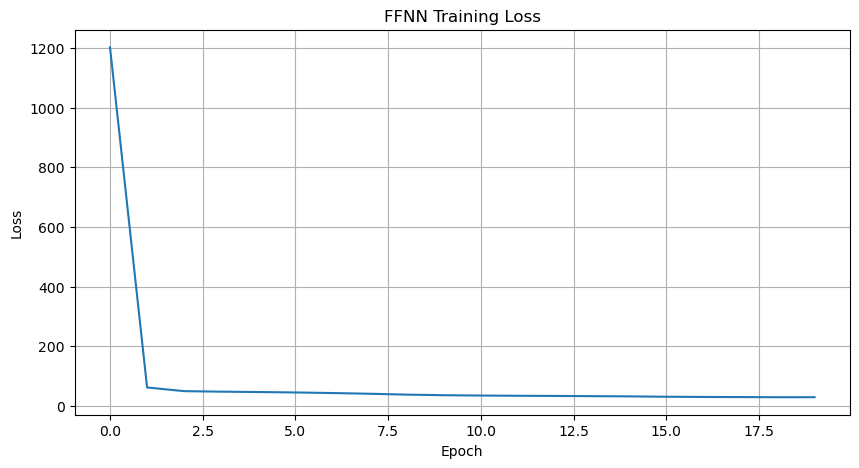

Episode 22/100: Evaluating FFNN
Episode 22/100 | Reward: 444.0310
Train MSE: 30.2269 | Train Female MSE: 9.6912
Val MSE: 81.6683 | Val Female MSE: 22.3835
Test MSE: 70.4478 | Test Female MSE: 34.5001

--------------------------------

Episode 23/100: Generating Synthetic Data
Episode 23/100: Training FFNN


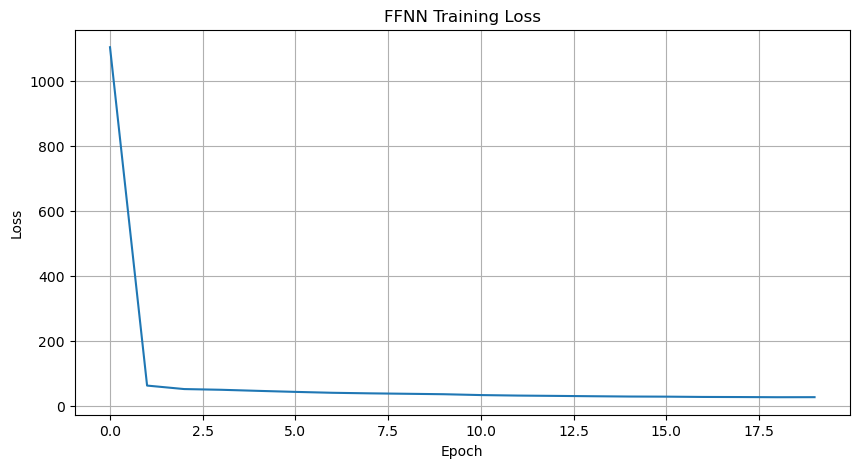

Episode 23/100: Evaluating FFNN
Episode 23/100 | Reward: -483.9756
Train MSE: 25.6413 | Train Female MSE: 5.5475
Val MSE: 112.6315 | Val Female MSE: 82.8122
Test MSE: 49.2773 | Test Female MSE: 3.2047

--------------------------------

Episode 24/100: Generating Synthetic Data
Episode 24/100: Training FFNN


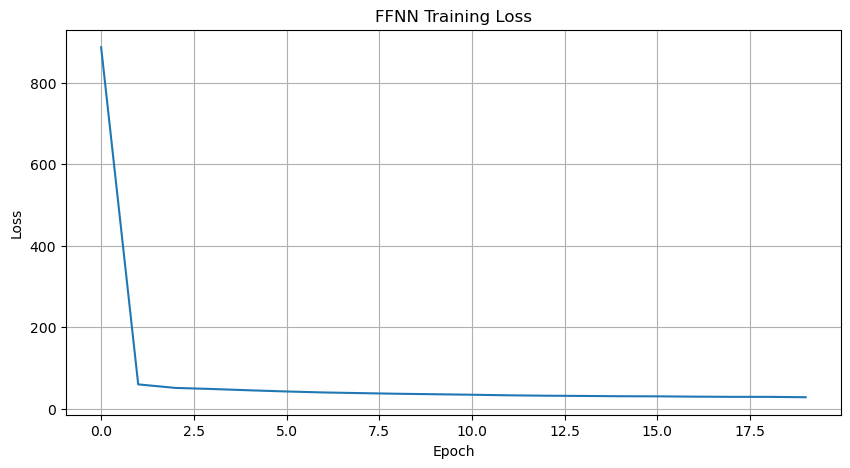

Episode 24/100: Evaluating FFNN
Episode 24/100 | Reward: -63.0827
Train MSE: 27.6788 | Train Female MSE: 5.5172
Val MSE: 89.9273 | Val Female MSE: 18.6112
Test MSE: 52.4207 | Test Female MSE: 5.0860

--------------------------------

Episode 25/100: Generating Synthetic Data
Episode 25/100: Training FFNN


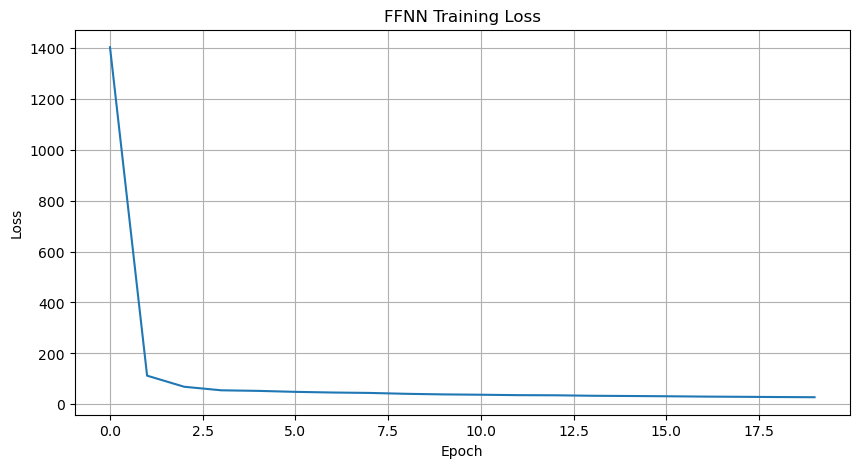

Episode 25/100: Evaluating FFNN
Episode 25/100 | Reward: 253.4578
Train MSE: 29.4858 | Train Female MSE: 9.0772
Val MSE: 70.4756 | Val Female MSE: 9.6312
Test MSE: 61.0337 | Test Female MSE: 26.4643

--------------------------------

Episode 26/100: Generating Synthetic Data
Episode 26/100: Training FFNN


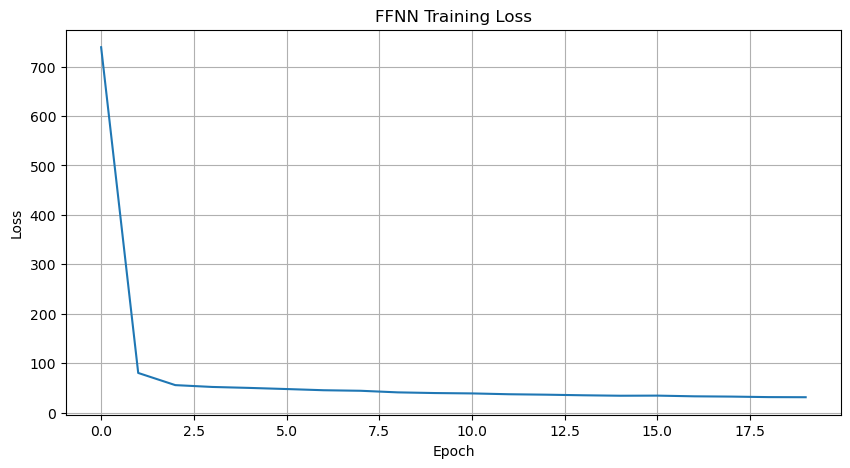

Episode 26/100: Evaluating FFNN
Episode 26/100 | Reward: -1917.0635
Train MSE: 30.7083 | Train Female MSE: 8.2967
Val MSE: 270.9377 | Val Female MSE: 85.2997
Test MSE: 82.8026 | Test Female MSE: 12.4804

--------------------------------

Episode 27/100: Generating Synthetic Data
Episode 27/100: Training FFNN


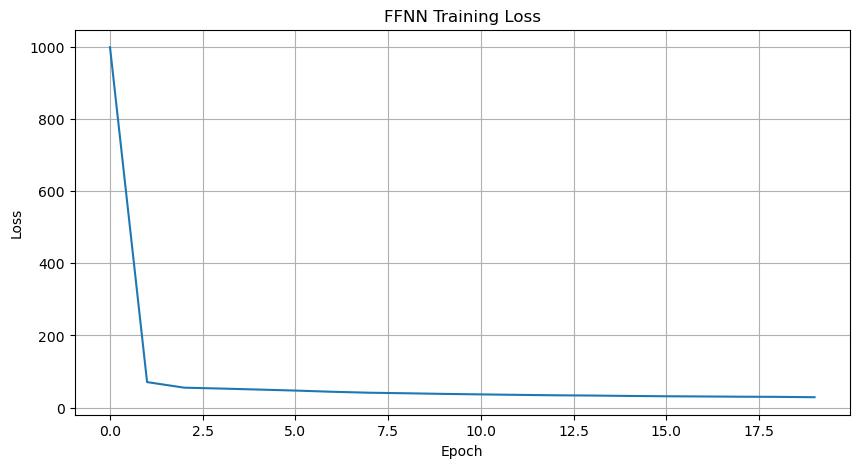

Episode 27/100: Evaluating FFNN
Episode 27/100 | Reward: -2408.0409
Train MSE: 28.4156 | Train Female MSE: 7.6130
Val MSE: 318.8732 | Val Female MSE: 25.4294
Test MSE: 49.8502 | Test Female MSE: 5.7768

--------------------------------

Episode 28/100: Generating Synthetic Data
Episode 28/100: Training FFNN


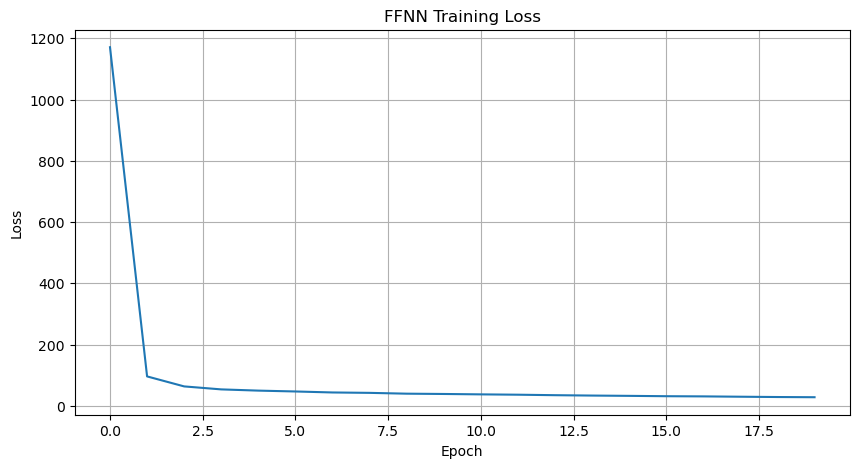

Episode 28/100: Evaluating FFNN
Episode 28/100 | Reward: -1089.2373
Train MSE: 26.8497 | Train Female MSE: 5.1830
Val MSE: 197.6394 | Val Female MSE: 34.2634
Test MSE: 46.0809 | Test Female MSE: 3.1810

--------------------------------

Episode 29/100: Generating Synthetic Data
Episode 29/100: Training FFNN


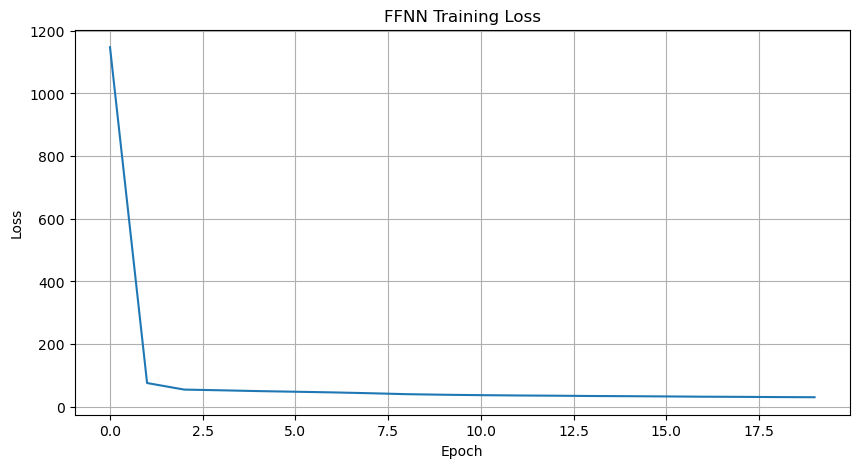

Episode 29/100: Evaluating FFNN
Episode 29/100 | Reward: -1138.2743
Train MSE: 35.3245 | Train Female MSE: 8.4930
Val MSE: 200.0418 | Val Female MSE: 60.2937
Test MSE: 42.6262 | Test Female MSE: 14.0776

--------------------------------

Episode 30/100: Generating Synthetic Data
Episode 30/100: Training FFNN


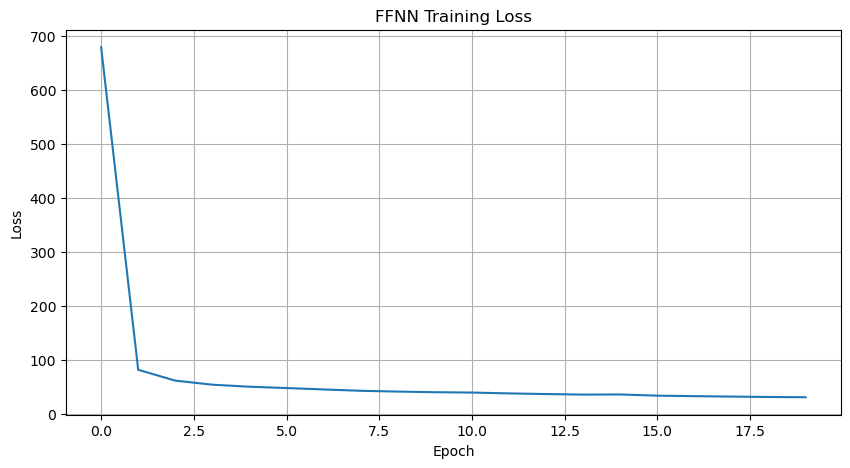

Episode 30/100: Evaluating FFNN
Episode 30/100 | Reward: -72.0308
Train MSE: 30.2711 | Train Female MSE: 6.1817
Val MSE: 126.7148 | Val Female MSE: 23.6623
Test MSE: 65.4779 | Test Female MSE: 3.7207

--------------------------------

Episode 31/100: Generating Synthetic Data
Episode 31/100: Training FFNN


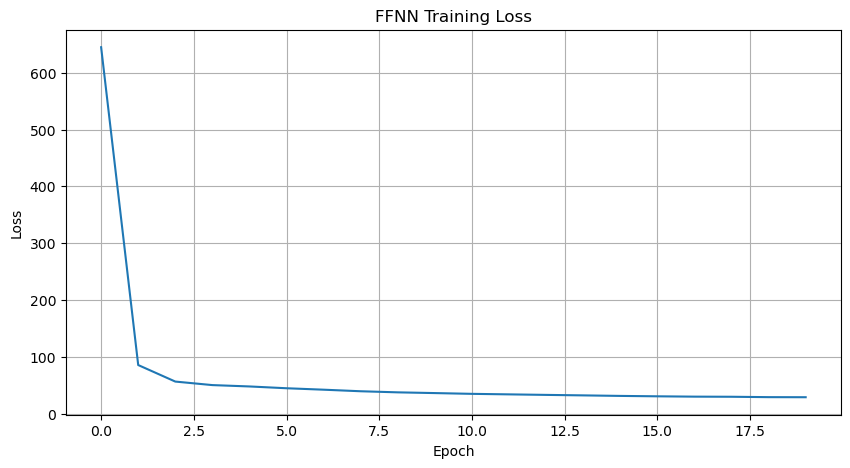

Episode 31/100: Evaluating FFNN
Episode 31/100 | Reward: -674.2307
Train MSE: 28.9444 | Train Female MSE: 5.4803
Val MSE: 166.3601 | Val Female MSE: 38.0032
Test MSE: 64.6294 | Test Female MSE: 3.4056

--------------------------------

Episode 32/100: Generating Synthetic Data
Episode 32/100: Training FFNN


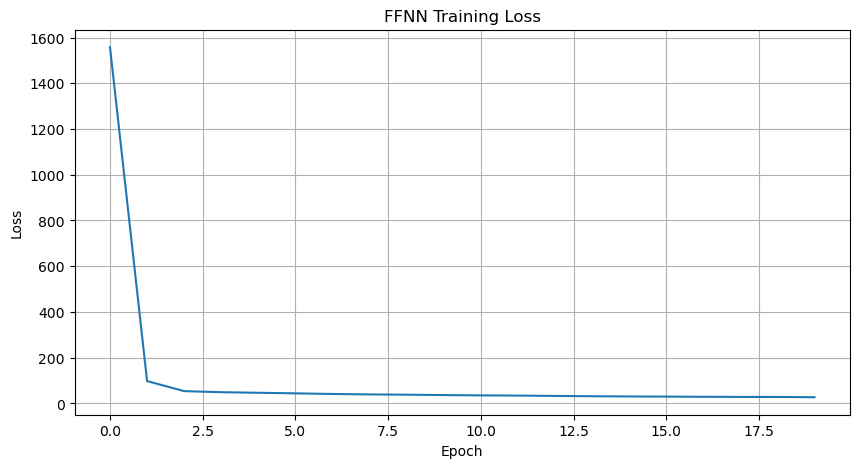

Episode 32/100: Evaluating FFNN
Episode 32/100 | Reward: -2512.4415
Train MSE: 26.5276 | Train Female MSE: 6.2036
Val MSE: 335.9474 | Val Female MSE: 99.1585
Test MSE: 83.1598 | Test Female MSE: 24.6661

--------------------------------

Episode 33/100: Generating Synthetic Data
Episode 33/100: Training FFNN


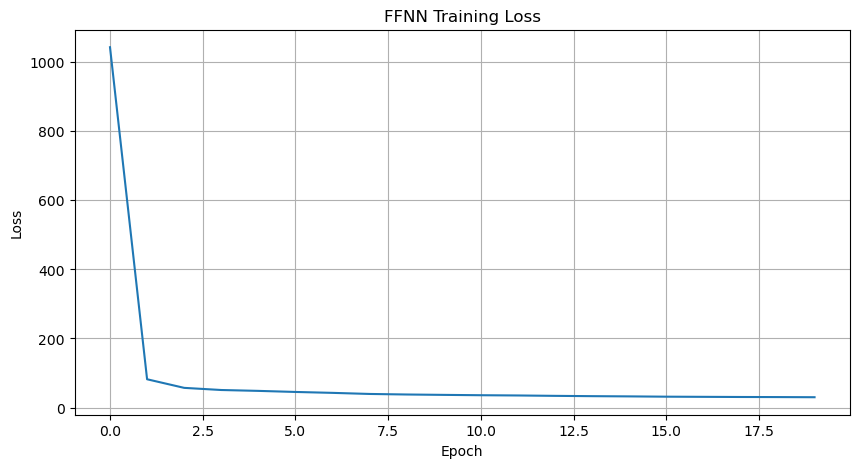

Episode 33/100: Evaluating FFNN
Episode 33/100 | Reward: -1797.6456
Train MSE: 29.7330 | Train Female MSE: 4.8047
Val MSE: 259.9069 | Val Female MSE: 39.3330
Test MSE: 67.7164 | Test Female MSE: 5.7620

--------------------------------

Episode 34/100: Generating Synthetic Data
Episode 34/100: Training FFNN


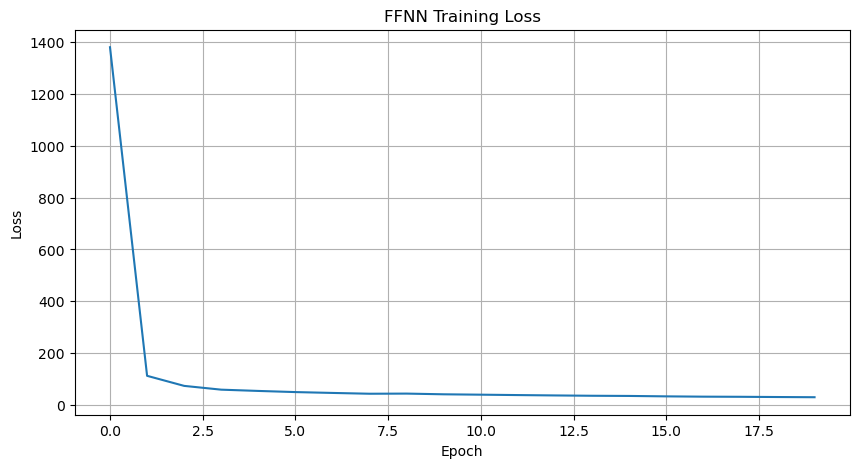

Episode 34/100: Evaluating FFNN
Episode 34/100 | Reward: -4207.3614
Train MSE: 29.1455 | Train Female MSE: 4.6200
Val MSE: 503.6033 | Val Female MSE: 160.7474
Test MSE: 77.7075 | Test Female MSE: 7.3662

--------------------------------

Episode 35/100: Generating Synthetic Data
Episode 35/100: Training FFNN


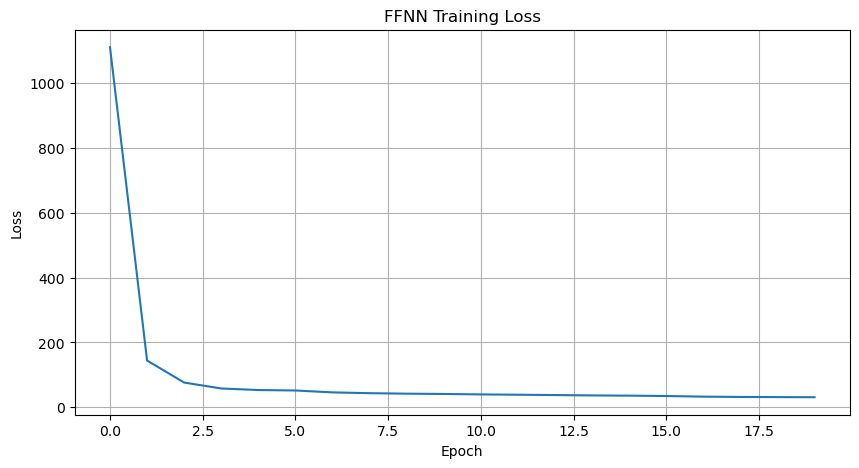

Episode 35/100: Evaluating FFNN
Episode 35/100 | Reward: -2888.4425
Train MSE: 30.5721 | Train Female MSE: 7.5433
Val MSE: 368.7586 | Val Female MSE: 82.9414
Test MSE: 62.9039 | Test Female MSE: 18.2694

--------------------------------

Episode 36/100: Generating Synthetic Data
Episode 36/100: Training FFNN


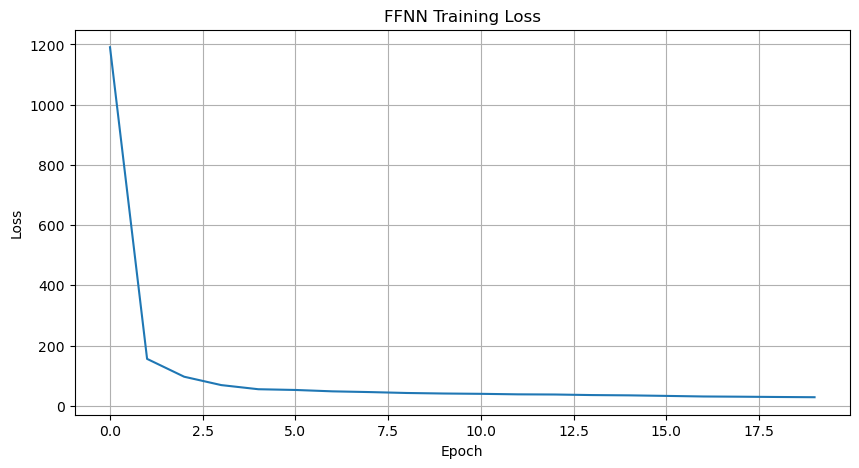

Episode 36/100: Evaluating FFNN
Episode 36/100 | Reward: -1629.3885
Train MSE: 28.0229 | Train Female MSE: 6.4051
Val MSE: 245.7135 | Val Female MSE: 36.6045
Test MSE: 55.6485 | Test Female MSE: 14.0925

--------------------------------

Episode 37/100: Generating Synthetic Data
Episode 37/100: Training FFNN


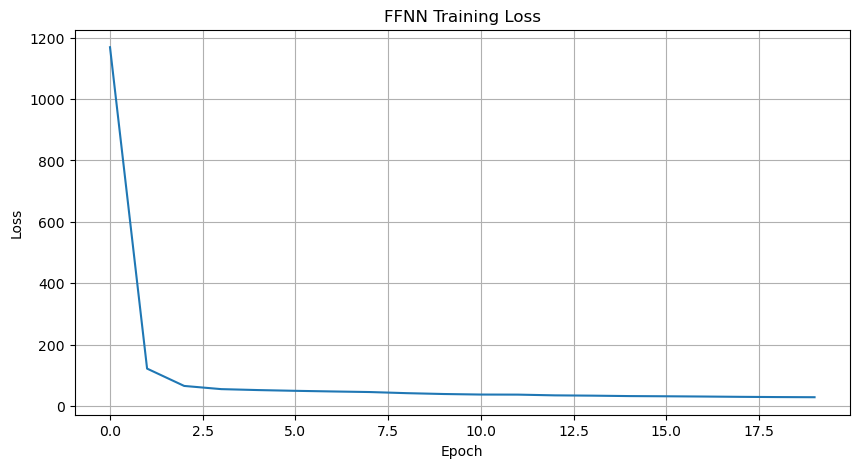

Episode 37/100: Evaluating FFNN
Episode 37/100 | Reward: -1927.2014
Train MSE: 28.4181 | Train Female MSE: 6.8780
Val MSE: 266.9509 | Val Female MSE: 14.8385
Test MSE: 51.0249 | Test Female MSE: 10.7125

--------------------------------

Episode 38/100: Generating Synthetic Data
Episode 38/100: Training FFNN


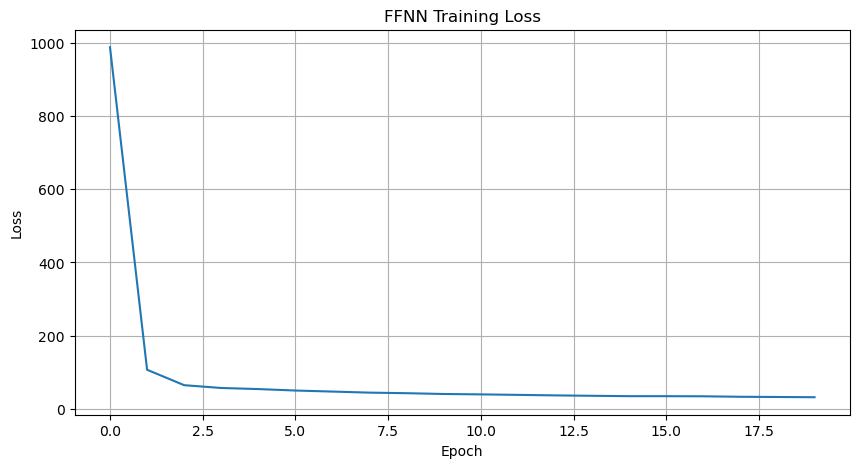

Episode 38/100: Evaluating FFNN
Episode 38/100 | Reward: -285.6358
Train MSE: 31.1398 | Train Female MSE: 6.5143
Val MSE: 106.1336 | Val Female MSE: 14.7221
Test MSE: 58.0446 | Test Female MSE: 11.6983

--------------------------------

Episode 39/100: Generating Synthetic Data
Episode 39/100: Training FFNN


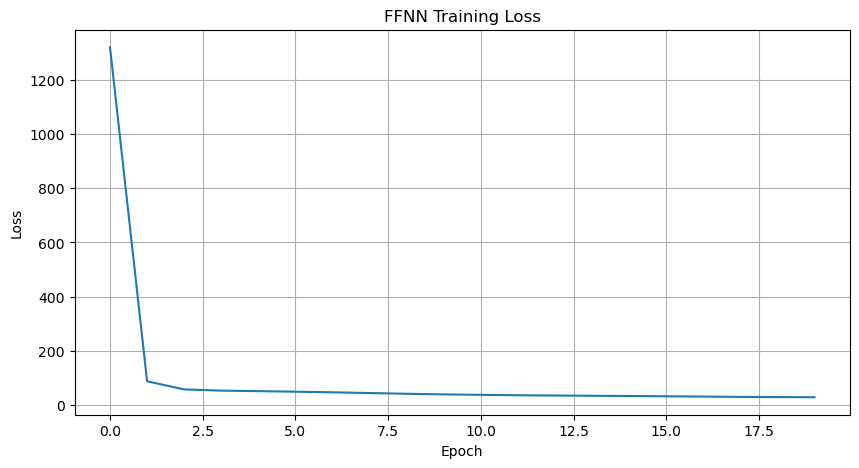

Episode 39/100: Evaluating FFNN
Episode 39/100 | Reward: -1951.1192
Train MSE: 29.2025 | Train Female MSE: 4.8470
Val MSE: 277.4702 | Val Female MSE: 18.3075
Test MSE: 43.6103 | Test Female MSE: 3.8889

--------------------------------

Episode 40/100: Generating Synthetic Data
Episode 40/100: Training FFNN


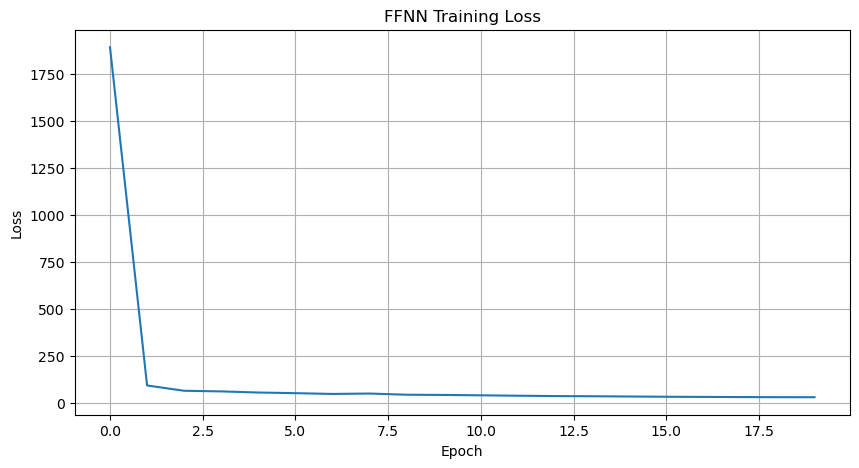

Episode 40/100: Evaluating FFNN
Episode 40/100 | Reward: -680.2819
Train MSE: 30.9935 | Train Female MSE: 9.2935
Val MSE: 146.9380 | Val Female MSE: 24.2507
Test MSE: 56.0035 | Test Female MSE: 10.1800

--------------------------------

Episode 41/100: Generating Synthetic Data
Episode 41/100: Training FFNN


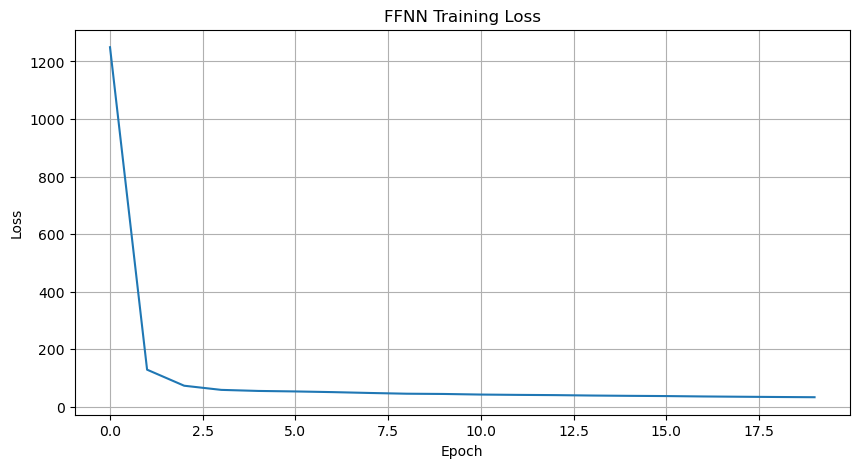

Episode 41/100: Evaluating FFNN
Episode 41/100 | Reward: -2014.0786
Train MSE: 32.1845 | Train Female MSE: 3.7075
Val MSE: 274.6898 | Val Female MSE: 27.0084
Test MSE: 56.4670 | Test Female MSE: 3.3726

--------------------------------

Episode 42/100: Generating Synthetic Data
Episode 42/100: Training FFNN


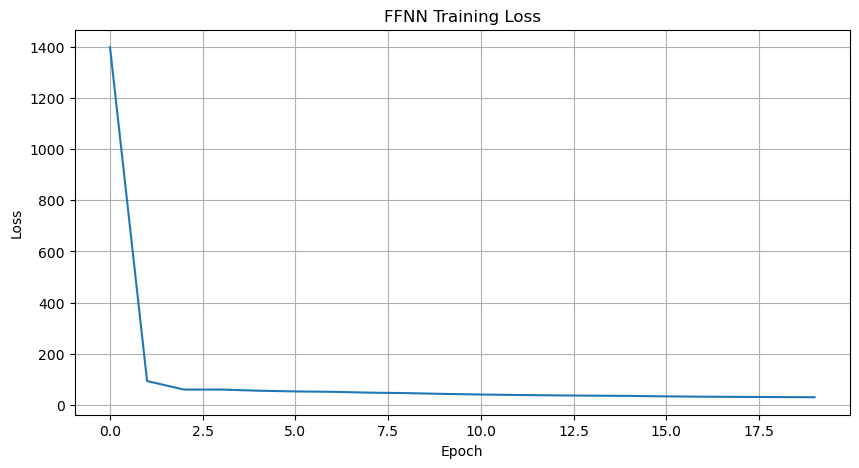

Episode 42/100: Evaluating FFNN
Episode 42/100 | Reward: -4038.7815
Train MSE: 34.1265 | Train Female MSE: 10.5938
Val MSE: 471.2704 | Val Female MSE: 86.3455
Test MSE: 103.0878 | Test Female MSE: 18.6828

--------------------------------

Episode 43/100: Generating Synthetic Data
Episode 43/100: Training FFNN


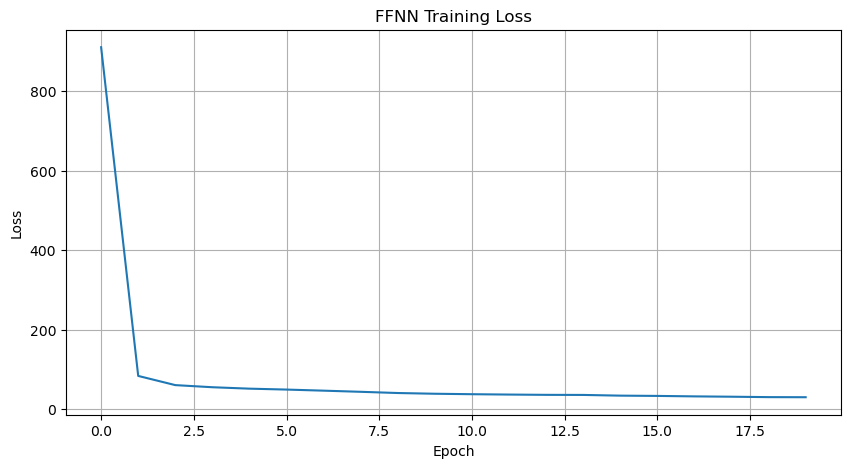

Episode 43/100: Evaluating FFNN
Episode 43/100 | Reward: -651.1840
Train MSE: 31.5362 | Train Female MSE: 6.7316
Val MSE: 129.7035 | Val Female MSE: 24.7215
Test MSE: 81.8298 | Test Female MSE: 6.5597

--------------------------------

Episode 44/100: Generating Synthetic Data
Episode 44/100: Training FFNN


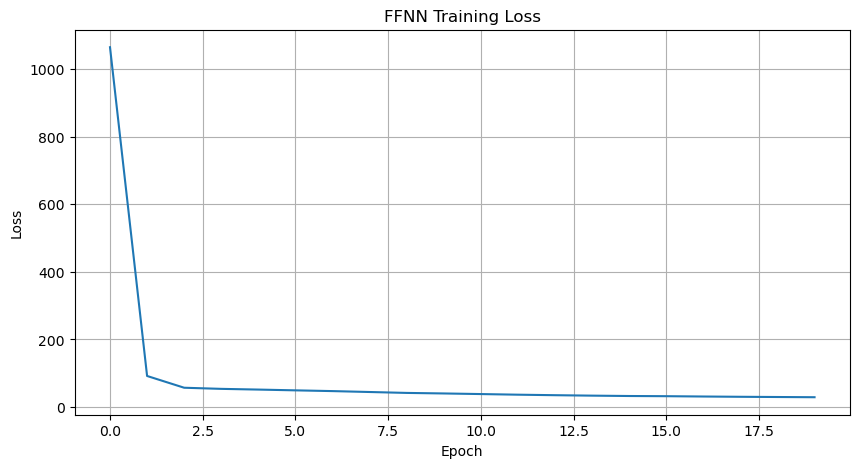

Episode 44/100: Evaluating FFNN
Episode 44/100 | Reward: -3971.9304
Train MSE: 27.8625 | Train Female MSE: 5.2796
Val MSE: 471.6994 | Val Female MSE: 144.9313
Test MSE: 40.6198 | Test Female MSE: 10.5914

--------------------------------

Episode 45/100: Generating Synthetic Data
Episode 45/100: Training FFNN


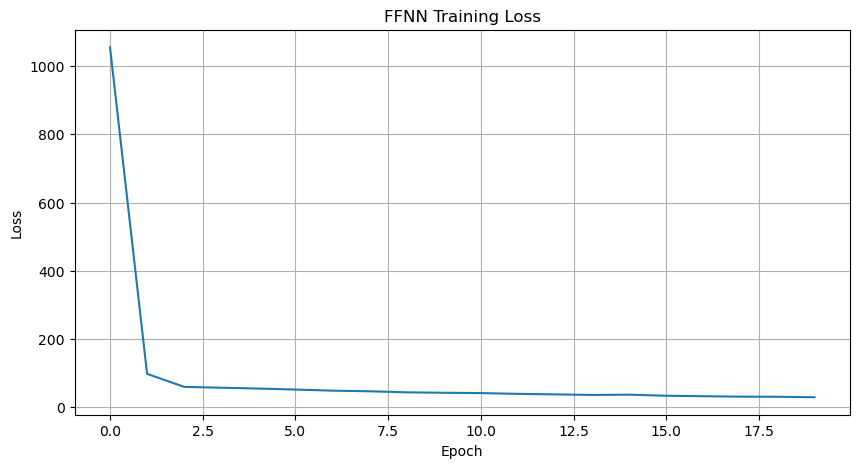

Episode 45/100: Evaluating FFNN
Episode 45/100 | Reward: 24.3545
Train MSE: 28.9629 | Train Female MSE: 8.6928
Val MSE: 82.1339 | Val Female MSE: 13.6531
Test MSE: 41.9976 | Test Female MSE: 12.2076

--------------------------------

Episode 46/100: Generating Synthetic Data
Episode 46/100: Training FFNN


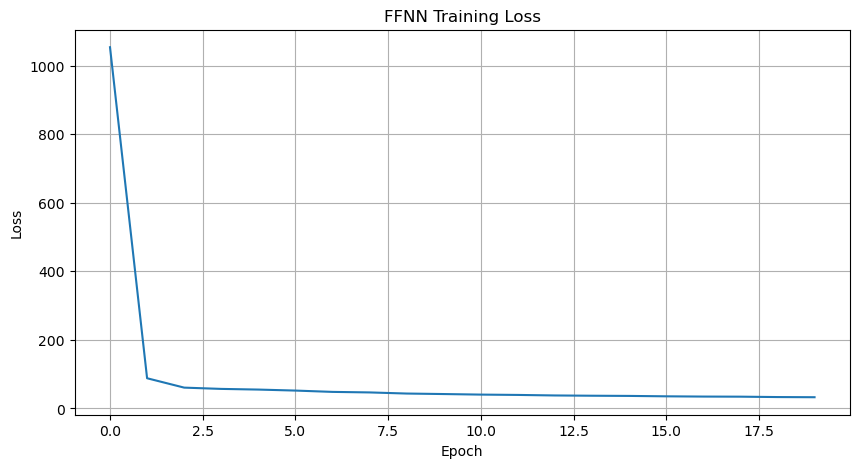

Episode 46/100: Evaluating FFNN
Episode 46/100 | Reward: -2546.4504
Train MSE: 31.2546 | Train Female MSE: 5.5108
Val MSE: 343.5704 | Val Female MSE: 132.0058
Test MSE: 75.0607 | Test Female MSE: 13.7251

--------------------------------

Episode 47/100: Generating Synthetic Data
Episode 47/100: Training FFNN


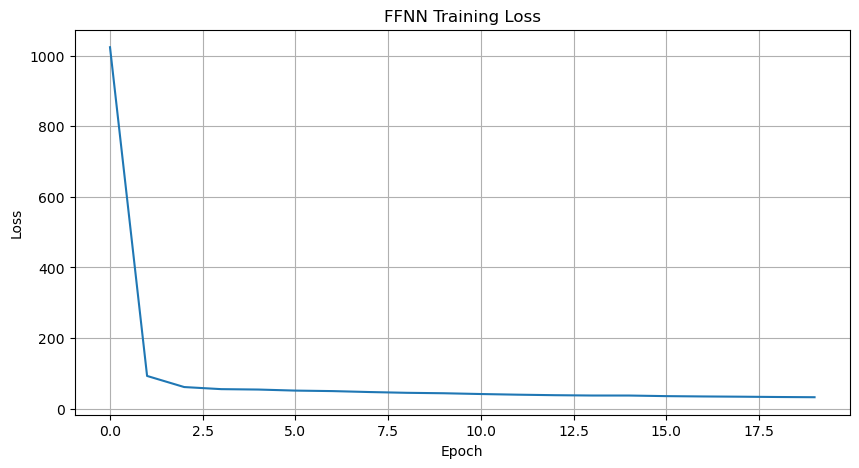

Episode 47/100: Evaluating FFNN
Episode 47/100 | Reward: -1540.2109
Train MSE: 30.6035 | Train Female MSE: 3.7320
Val MSE: 249.9062 | Val Female MSE: 59.4029
Test MSE: 63.4134 | Test Female MSE: 4.3466

--------------------------------

Episode 48/100: Generating Synthetic Data
Episode 48/100: Training FFNN


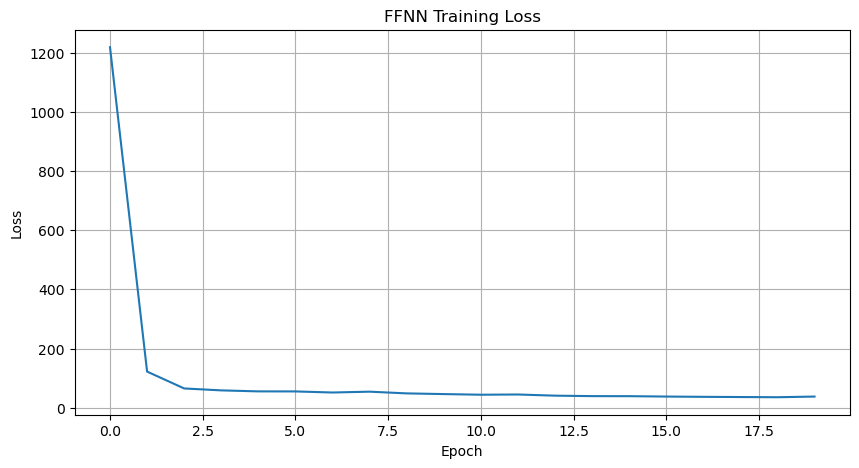

Episode 48/100: Evaluating FFNN
Episode 48/100 | Reward: -1128.6508
Train MSE: 34.4614 | Train Female MSE: 5.6759
Val MSE: 204.4402 | Val Female MSE: 49.1900
Test MSE: 80.0099 | Test Female MSE: 5.7477

--------------------------------

Episode 49/100: Generating Synthetic Data
Episode 49/100: Training FFNN


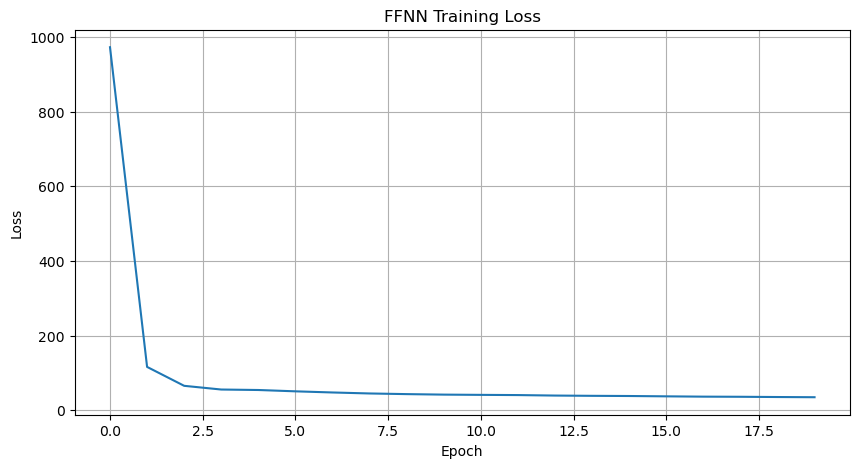

Episode 49/100: Evaluating FFNN
Episode 49/100 | Reward: -3676.7688
Train MSE: 34.5583 | Train Female MSE: 4.9469
Val MSE: 467.8710 | Val Female MSE: 104.6316
Test MSE: 61.9558 | Test Female MSE: 5.4682

--------------------------------

Episode 50/100: Generating Synthetic Data
Episode 50/100: Training FFNN


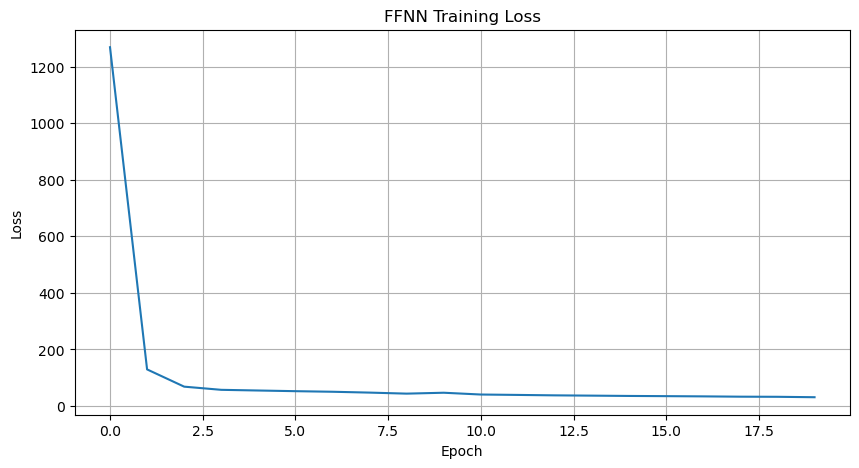

Episode 50/100: Evaluating FFNN
Episode 50/100 | Reward: -765.5292
Train MSE: 30.3245 | Train Female MSE: 7.5051
Val MSE: 176.0603 | Val Female MSE: 31.8483
Test MSE: 61.3699 | Test Female MSE: 12.3089

--------------------------------

Episode 51/100: Generating Synthetic Data
Episode 51/100: Training FFNN


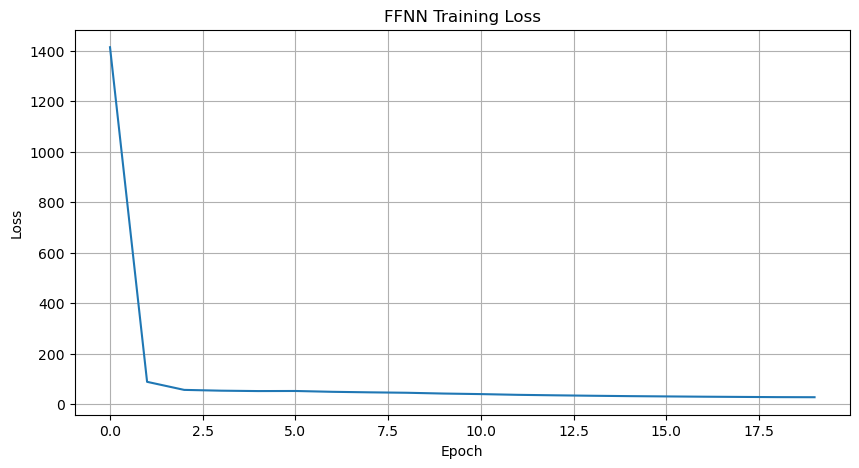

Episode 51/100: Evaluating FFNN
Episode 51/100 | Reward: -1725.3599
Train MSE: 28.4848 | Train Female MSE: 6.1542
Val MSE: 266.6981 | Val Female MSE: 62.2936
Test MSE: 65.6142 | Test Female MSE: 33.2917

--------------------------------

Episode 52/100: Generating Synthetic Data
Episode 52/100: Training FFNN


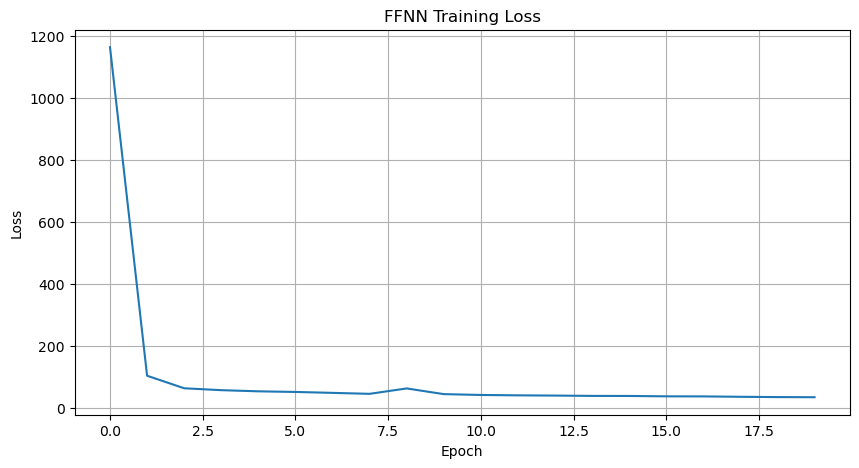

Episode 52/100: Evaluating FFNN
Episode 52/100 | Reward: -342.5360
Train MSE: 34.8455 | Train Female MSE: 5.4873
Val MSE: 128.1405 | Val Female MSE: 32.8562
Test MSE: 68.9781 | Test Female MSE: 6.0551

--------------------------------

Episode 53/100: Generating Synthetic Data
Episode 53/100: Training FFNN


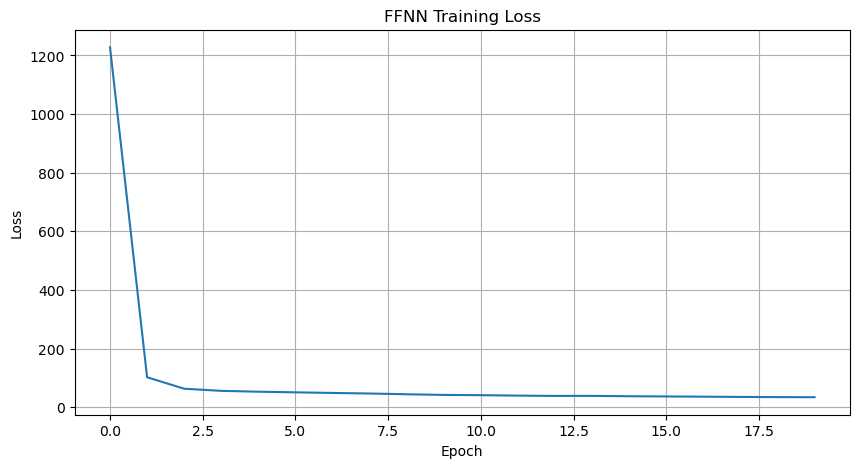

Episode 53/100: Evaluating FFNN
Episode 53/100 | Reward: -1071.9325
Train MSE: 35.6375 | Train Female MSE: 6.1549
Val MSE: 206.9598 | Val Female MSE: 77.6307
Test MSE: 83.3307 | Test Female MSE: 15.8678

--------------------------------

Episode 54/100: Generating Synthetic Data
Episode 54/100: Training FFNN


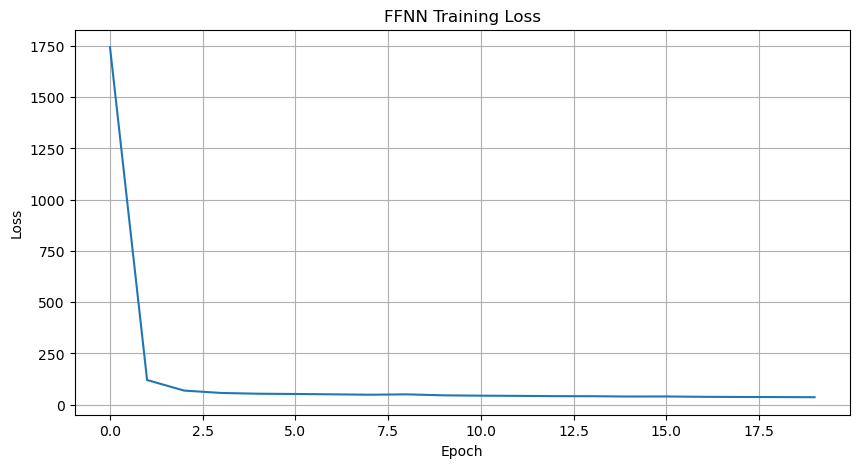

Episode 54/100: Evaluating FFNN
Episode 54/100 | Reward: -144.8773
Train MSE: 34.7369 | Train Female MSE: 4.9766
Val MSE: 116.6750 | Val Female MSE: 26.3066
Test MSE: 69.8382 | Test Female MSE: 8.3420

--------------------------------

Episode 55/100: Generating Synthetic Data
Episode 55/100: Training FFNN


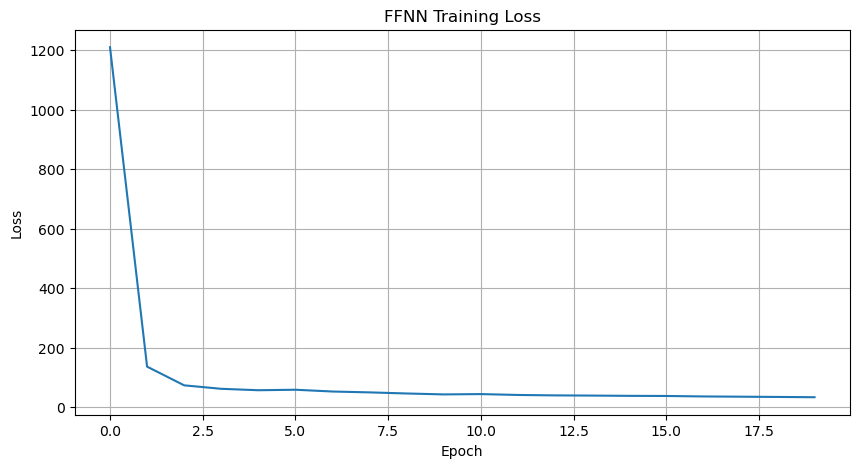

Episode 55/100: Evaluating FFNN
Episode 55/100 | Reward: -1082.2319
Train MSE: 34.2298 | Train Female MSE: 8.4348
Val MSE: 205.8401 | Val Female MSE: 68.8495
Test MSE: 93.4895 | Test Female MSE: 7.9661

--------------------------------

Episode 56/100: Generating Synthetic Data
Episode 56/100: Training FFNN


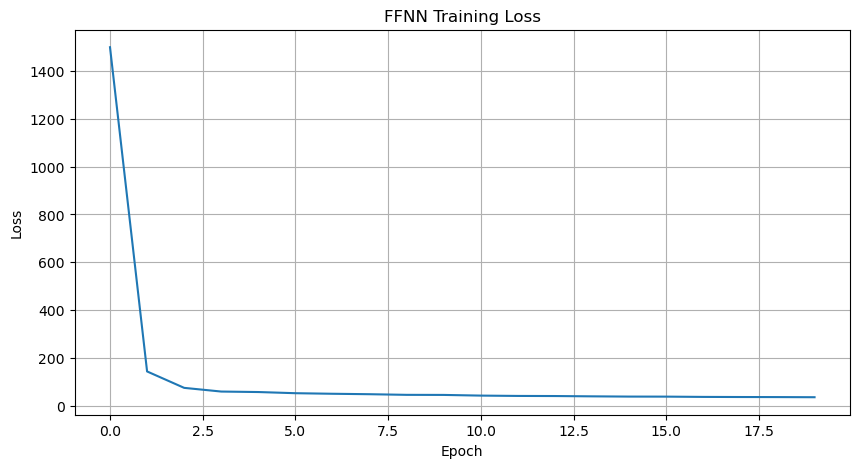

Episode 56/100: Evaluating FFNN
Episode 56/100 | Reward: -1713.1650
Train MSE: 35.6123 | Train Female MSE: 5.6902
Val MSE: 262.5038 | Val Female MSE: 66.9119
Test MSE: 62.9941 | Test Female MSE: 6.3663

--------------------------------

Episode 57/100: Generating Synthetic Data
Episode 57/100: Training FFNN


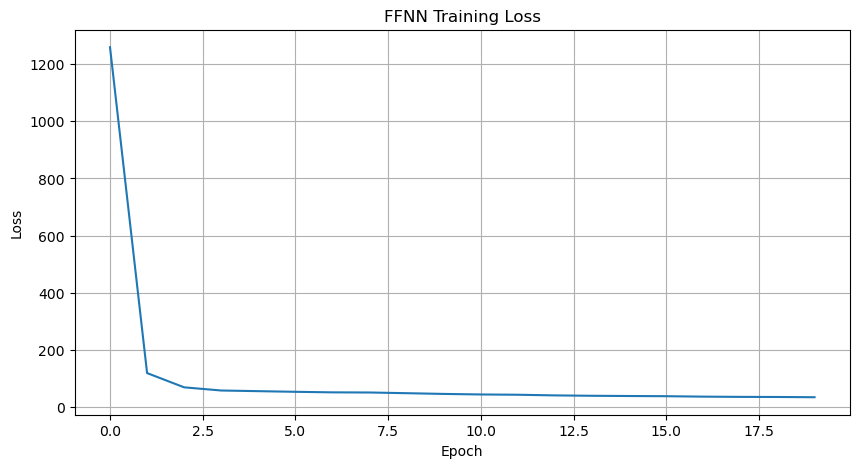

Episode 57/100: Evaluating FFNN
Episode 57/100 | Reward: -1274.6661
Train MSE: 33.0605 | Train Female MSE: 5.4206
Val MSE: 214.5380 | Val Female MSE: 78.3464
Test MSE: 73.9410 | Test Female MSE: 9.3388

--------------------------------

Episode 58/100: Generating Synthetic Data
Episode 58/100: Training FFNN


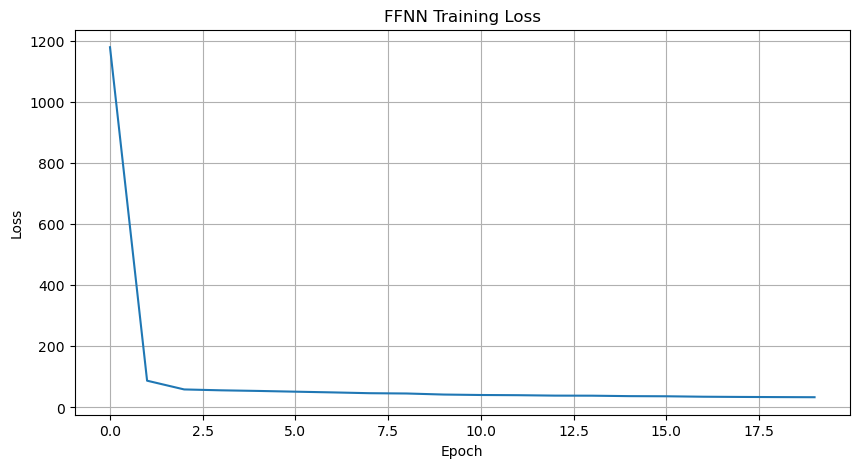

Episode 58/100: Evaluating FFNN
Episode 58/100 | Reward: -1166.5667
Train MSE: 33.4274 | Train Female MSE: 6.3133
Val MSE: 218.7316 | Val Female MSE: 56.1361
Test MSE: 71.6461 | Test Female MSE: 5.2262

--------------------------------

Episode 59/100: Generating Synthetic Data
Episode 59/100: Training FFNN


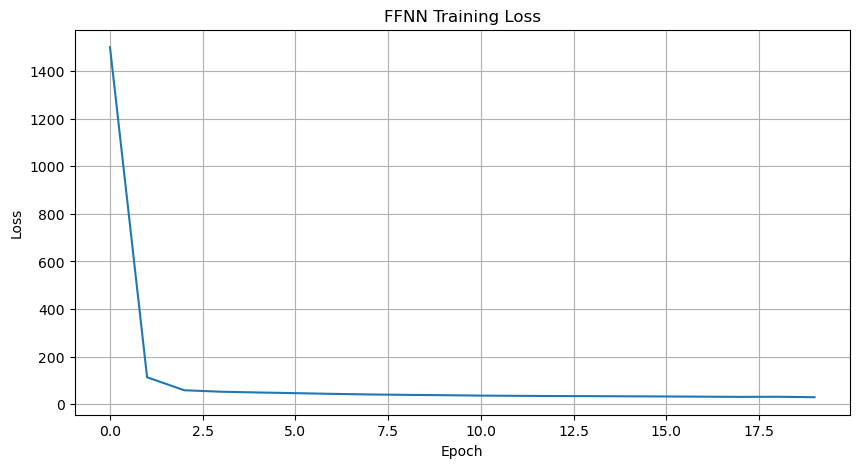

Episode 59/100: Evaluating FFNN
Episode 59/100 | Reward: -1997.2062
Train MSE: 29.1790 | Train Female MSE: 5.6450
Val MSE: 319.4290 | Val Female MSE: 107.0668
Test MSE: 76.7589 | Test Female MSE: 22.1013

--------------------------------

Episode 60/100: Generating Synthetic Data
Episode 60/100: Training FFNN


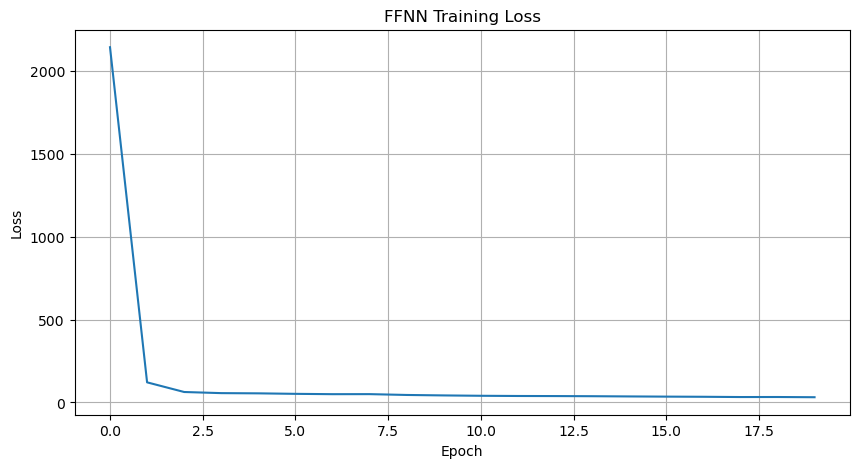

Episode 60/100: Evaluating FFNN
Episode 60/100 | Reward: -2649.3448
Train MSE: 30.9193 | Train Female MSE: 6.9240
Val MSE: 413.7652 | Val Female MSE: 71.0123
Test MSE: 69.6969 | Test Female MSE: 7.8113

--------------------------------

Episode 61/100: Generating Synthetic Data
Episode 61/100: Training FFNN


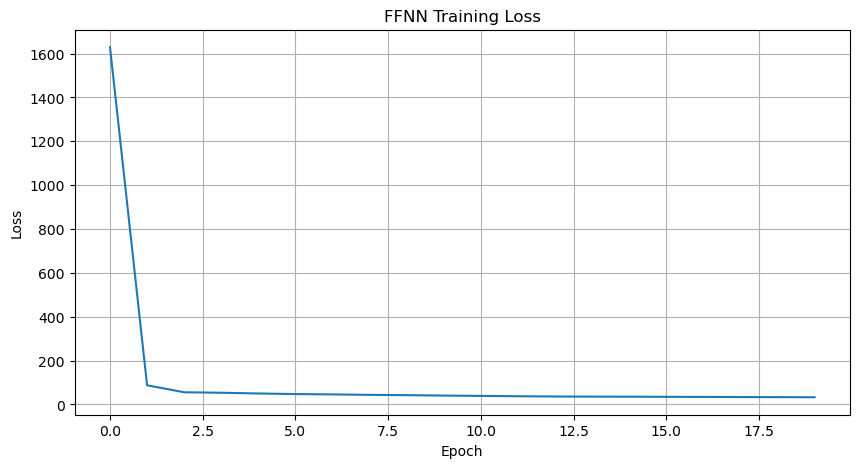

Episode 61/100: Evaluating FFNN
Episode 61/100 | Reward: -117.6095
Train MSE: 33.9489 | Train Female MSE: 8.2074
Val MSE: 171.6075 | Val Female MSE: 40.0754
Test MSE: 58.1312 | Test Female MSE: 4.6650

--------------------------------

Episode 62/100: Generating Synthetic Data
Episode 62/100: Training FFNN


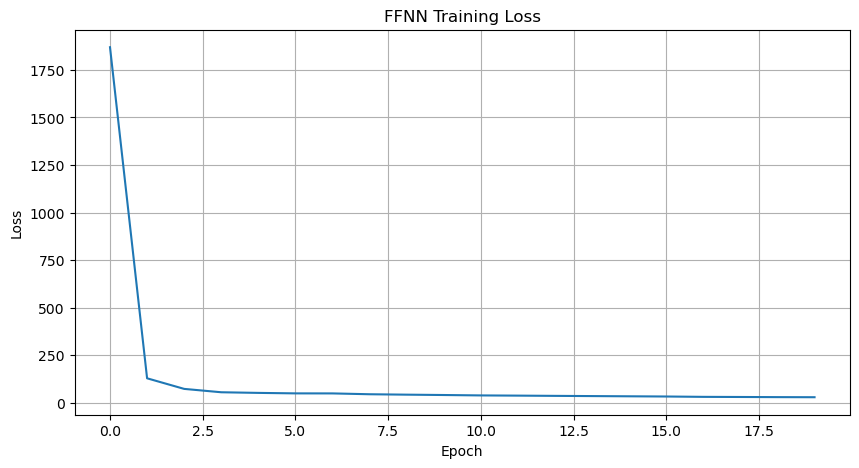

Episode 62/100: Evaluating FFNN
Episode 62/100 | Reward: 72.1609
Train MSE: 31.6825 | Train Female MSE: 7.5784
Val MSE: 149.1908 | Val Female MSE: 13.7873
Test MSE: 53.0070 | Test Female MSE: 7.3867

--------------------------------

Episode 63/100: Generating Synthetic Data
Episode 63/100: Training FFNN


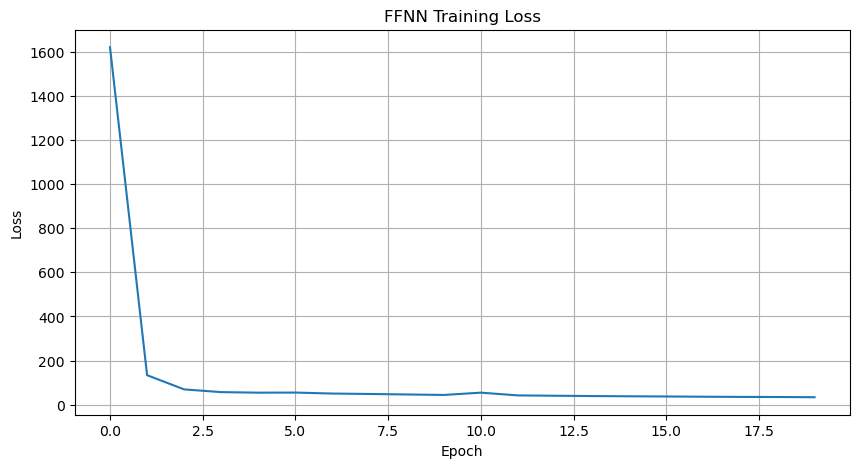

Episode 63/100: Evaluating FFNN
Episode 63/100 | Reward: 615.7844
Train MSE: 32.3426 | Train Female MSE: 8.0025
Val MSE: 96.5641 | Val Female MSE: 10.9314
Test MSE: 56.6322 | Test Female MSE: 3.3842

--------------------------------

Episode 64/100: Generating Synthetic Data
Episode 64/100: Training FFNN


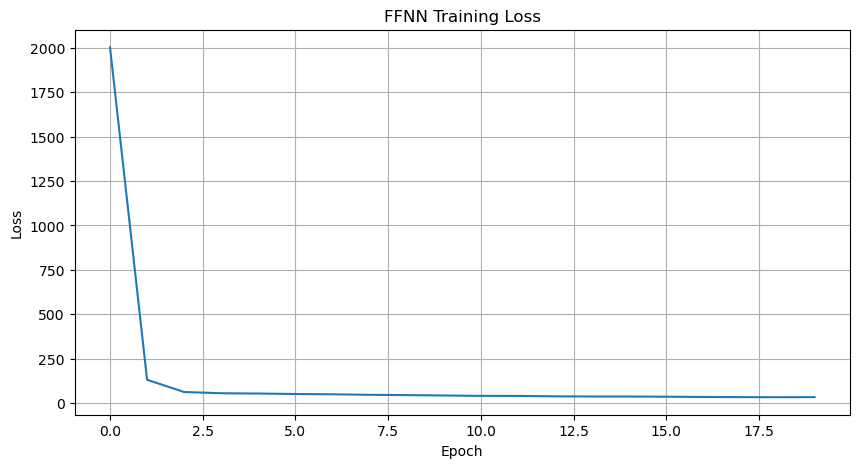

Episode 64/100: Evaluating FFNN
Episode 64/100 | Reward: 256.1684
Train MSE: 35.1526 | Train Female MSE: 7.8197
Val MSE: 141.3040 | Val Female MSE: 26.1487
Test MSE: 69.4132 | Test Female MSE: 6.0124

--------------------------------

Episode 65/100: Generating Synthetic Data
Episode 65/100: Training FFNN


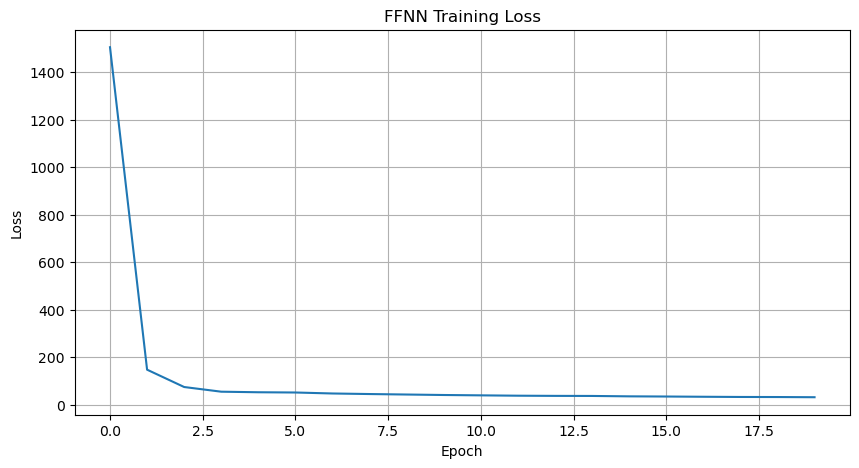

Episode 65/100: Evaluating FFNN
Episode 65/100 | Reward: -1222.7755
Train MSE: 31.6012 | Train Female MSE: 6.8019
Val MSE: 272.7652 | Val Female MSE: 92.1810
Test MSE: 76.1169 | Test Female MSE: 5.1802

--------------------------------

Episode 66/100: Generating Synthetic Data
Episode 66/100: Training FFNN


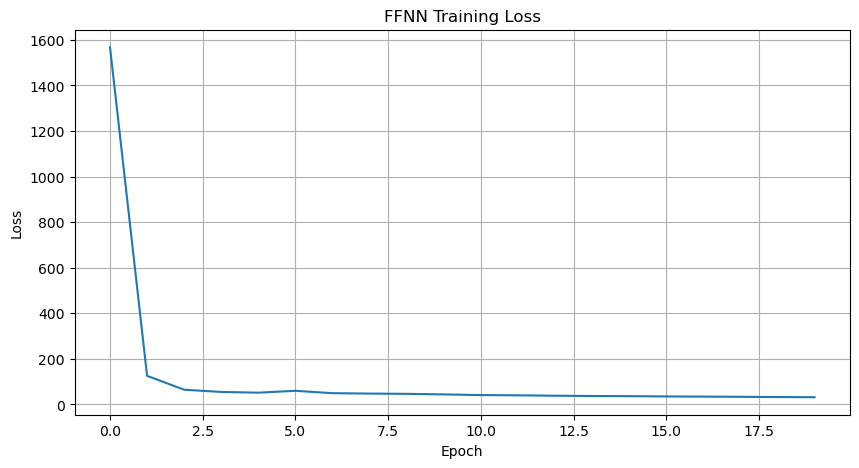

Episode 66/100: Evaluating FFNN
Episode 66/100 | Reward: -1655.6758
Train MSE: 30.7689 | Train Female MSE: 5.6901
Val MSE: 305.9341 | Val Female MSE: 75.8848
Test MSE: 54.0870 | Test Female MSE: 6.0920

--------------------------------

Episode 67/100: Generating Synthetic Data
Episode 67/100: Training FFNN


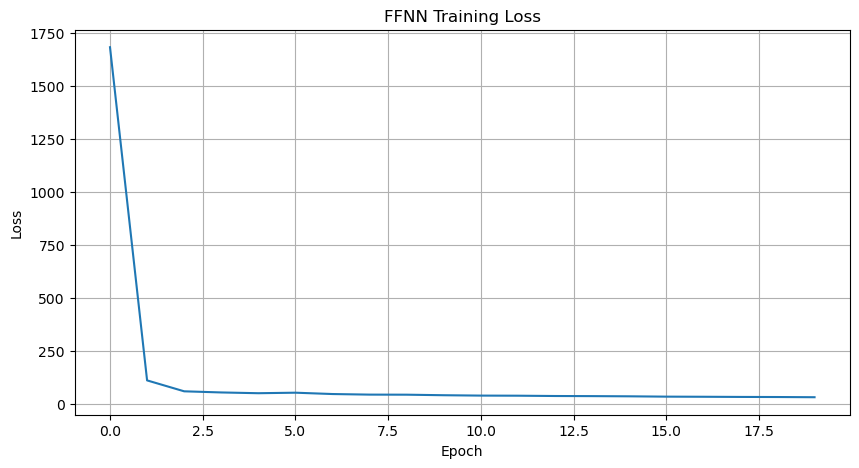

Episode 67/100: Evaluating FFNN
Episode 67/100 | Reward: -178.5819
Train MSE: 31.0550 | Train Female MSE: 7.1793
Val MSE: 148.5447 | Val Female MSE: 41.2198
Test MSE: 73.4885 | Test Female MSE: 11.4382

--------------------------------

Episode 68/100: Generating Synthetic Data
Episode 68/100: Training FFNN


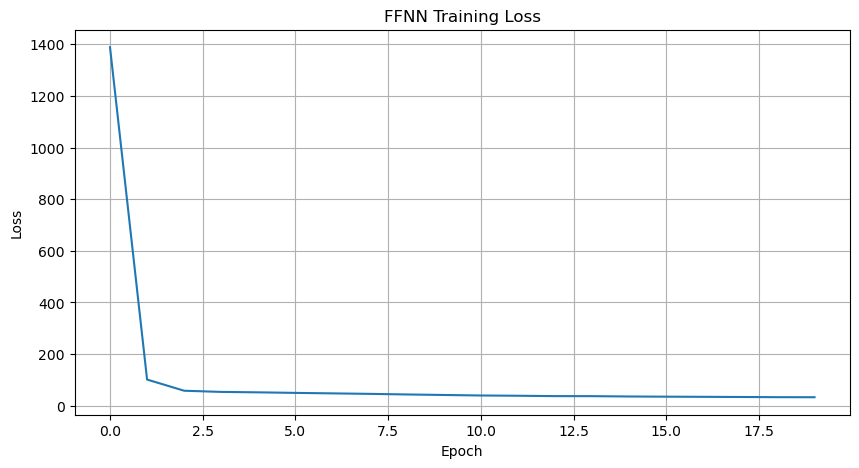

Episode 68/100: Evaluating FFNN
Episode 68/100 | Reward: -618.8286
Train MSE: 34.2936 | Train Female MSE: 11.0769
Val MSE: 183.1941 | Val Female MSE: 38.3957
Test MSE: 70.2381 | Test Female MSE: 7.5354

--------------------------------

Episode 69/100: Generating Synthetic Data
Episode 69/100: Training FFNN


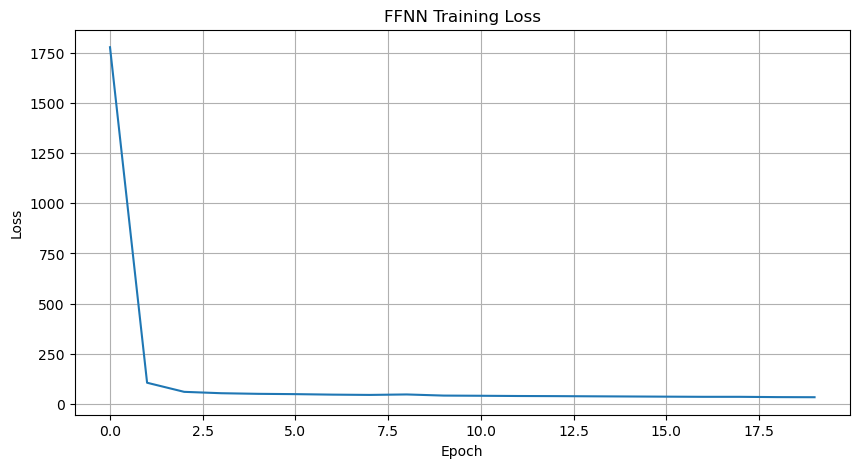

Episode 69/100: Evaluating FFNN
Episode 69/100 | Reward: 266.3075
Train MSE: 34.5915 | Train Female MSE: 7.4369
Val MSE: 103.7401 | Val Female MSE: 17.1526
Test MSE: 50.5508 | Test Female MSE: 6.3979

--------------------------------

Episode 70/100: Generating Synthetic Data
Episode 70/100: Training FFNN


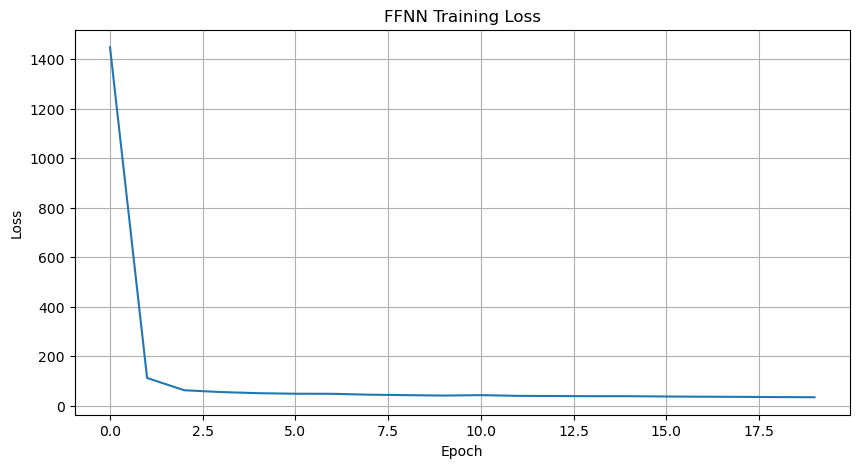

Episode 70/100: Evaluating FFNN
Episode 70/100 | Reward: -255.5322
Train MSE: 34.2579 | Train Female MSE: 6.3948
Val MSE: 164.1546 | Val Female MSE: 30.3302
Test MSE: 62.8661 | Test Female MSE: 7.6979

--------------------------------

Episode 71/100: Generating Synthetic Data
Episode 71/100: Training FFNN


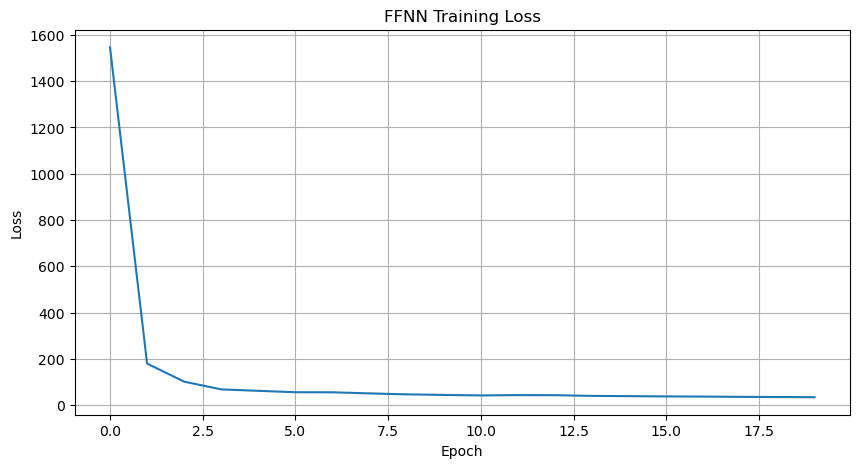

Episode 71/100: Evaluating FFNN
Episode 71/100 | Reward: 63.6609
Train MSE: 33.8128 | Train Female MSE: 6.5420
Val MSE: 141.0940 | Val Female MSE: 34.9742
Test MSE: 71.2297 | Test Female MSE: 4.3513

--------------------------------

Episode 72/100: Generating Synthetic Data
Episode 72/100: Training FFNN


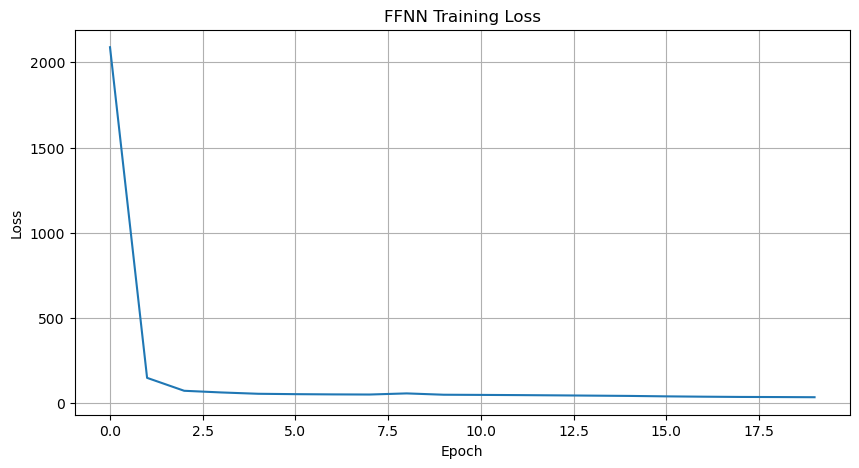

Episode 72/100: Evaluating FFNN
Episode 72/100 | Reward: -29.3391
Train MSE: 35.8992 | Train Female MSE: 7.8552
Val MSE: 152.1425 | Val Female MSE: 21.5722
Test MSE: 51.9235 | Test Female MSE: 4.3679

--------------------------------

Episode 73/100: Generating Synthetic Data
Episode 73/100: Training FFNN


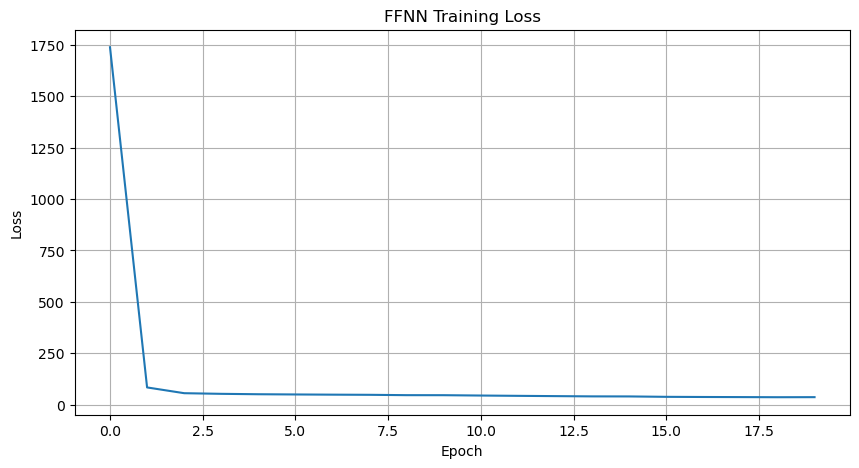

Episode 73/100: Evaluating FFNN
Episode 73/100 | Reward: 38.2381
Train MSE: 36.9313 | Train Female MSE: 9.5816
Val MSE: 154.0911 | Val Female MSE: 36.1368
Test MSE: 60.7281 | Test Female MSE: 6.2947

--------------------------------

Episode 74/100: Generating Synthetic Data
Episode 74/100: Training FFNN


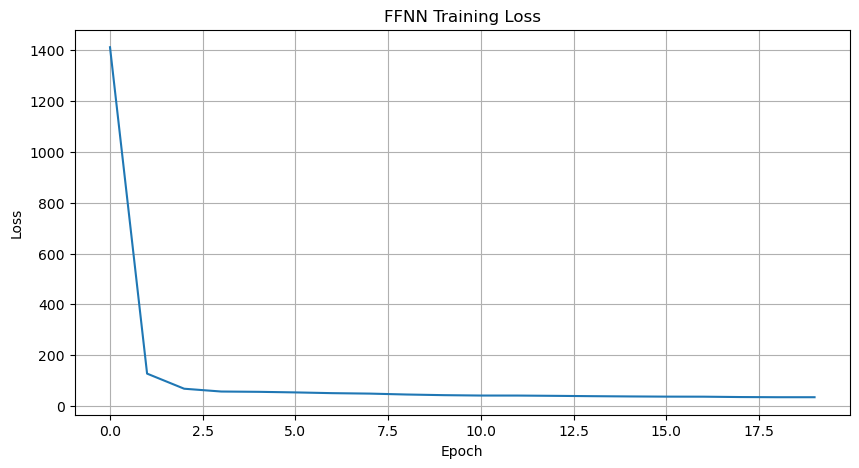

Episode 74/100: Evaluating FFNN
Episode 74/100 | Reward: 198.5772
Train MSE: 32.3334 | Train Female MSE: 6.9417
Val MSE: 144.7128 | Val Female MSE: 23.3477
Test MSE: 56.2461 | Test Female MSE: 3.9856

--------------------------------

Episode 75/100: Generating Synthetic Data
Episode 75/100: Training FFNN


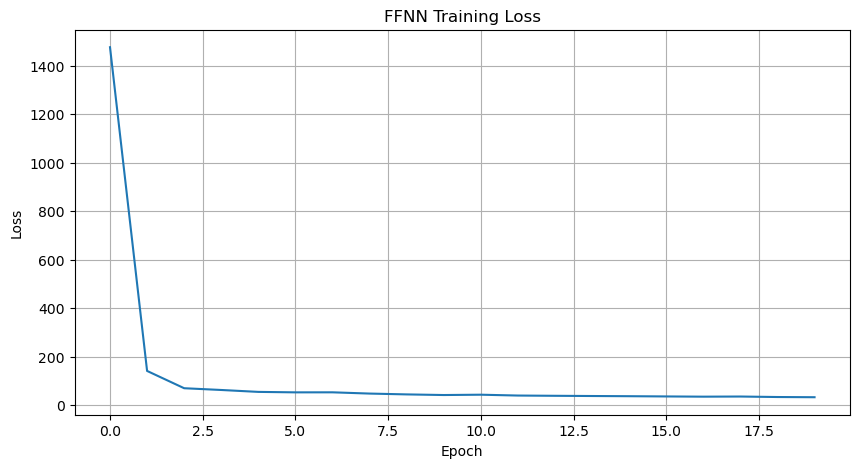

Episode 75/100: Evaluating FFNN
Episode 75/100 | Reward: 205.0804
Train MSE: 32.4410 | Train Female MSE: 5.1006
Val MSE: 156.1136 | Val Female MSE: 18.5858
Test MSE: 54.5644 | Test Female MSE: 2.0449

--------------------------------

Episode 76/100: Generating Synthetic Data
Episode 76/100: Training FFNN


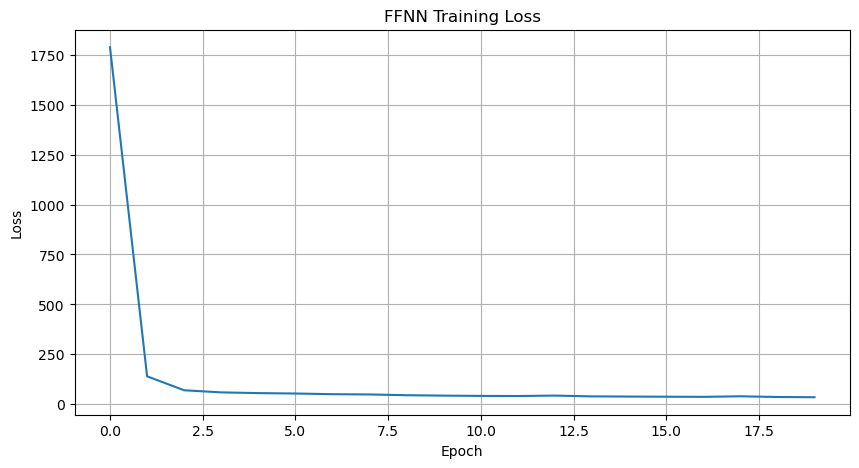

Episode 76/100: Evaluating FFNN
Episode 76/100 | Reward: -567.4288
Train MSE: 39.1264 | Train Female MSE: 8.5839
Val MSE: 235.2044 | Val Female MSE: 31.7430
Test MSE: 48.0206 | Test Female MSE: 6.9171

--------------------------------

Episode 77/100: Generating Synthetic Data
Episode 77/100: Training FFNN


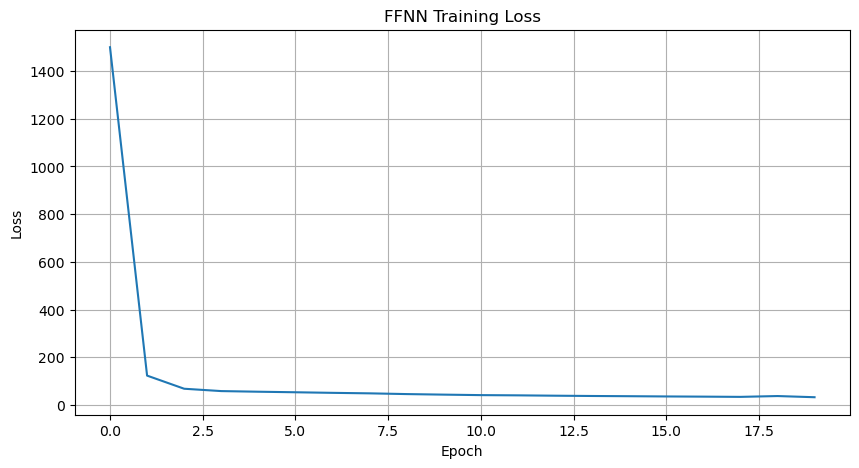

Episode 77/100: Evaluating FFNN
Episode 77/100 | Reward: -773.5829
Train MSE: 32.0434 | Train Female MSE: 5.6694
Val MSE: 248.8084 | Val Female MSE: 76.1280
Test MSE: 70.1986 | Test Female MSE: 28.0008

--------------------------------

Episode 78/100: Generating Synthetic Data
Episode 78/100: Training FFNN


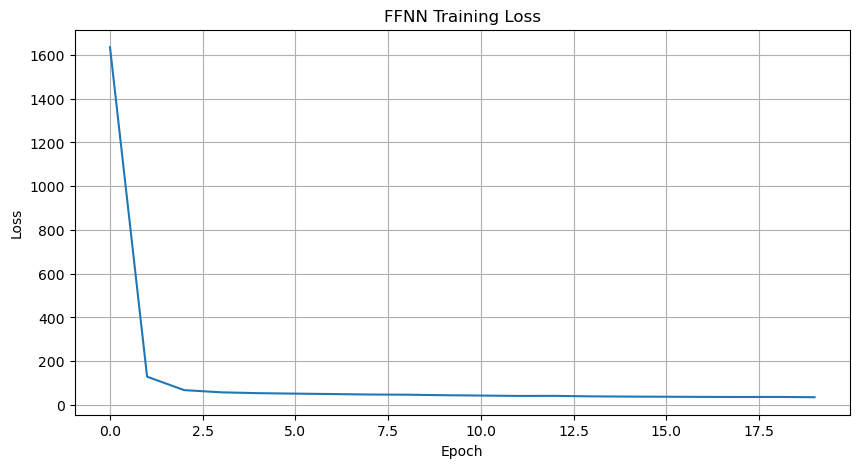

Episode 78/100: Evaluating FFNN
Episode 78/100 | Reward: 383.4325
Train MSE: 35.3237 | Train Female MSE: 5.8643
Val MSE: 121.8872 | Val Female MSE: 15.9164
Test MSE: 52.2485 | Test Female MSE: 2.9673

--------------------------------

Episode 79/100: Generating Synthetic Data
Episode 79/100: Training FFNN


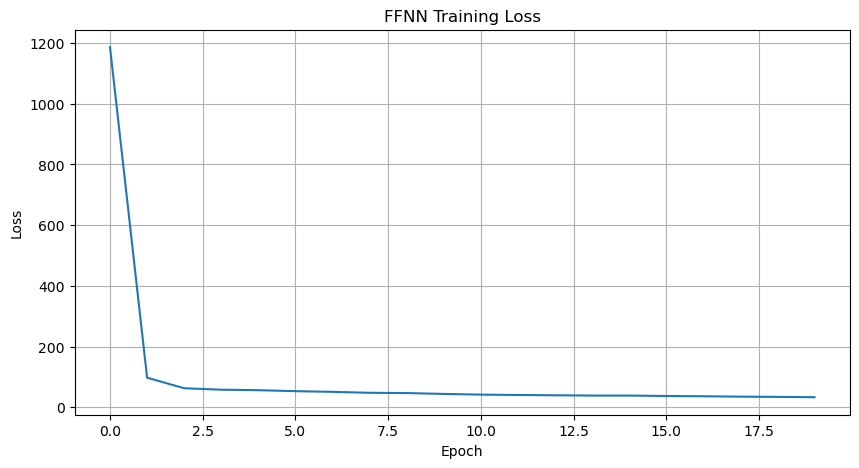

Episode 79/100: Evaluating FFNN
Episode 79/100 | Reward: -715.2258
Train MSE: 33.7347 | Train Female MSE: 8.7872
Val MSE: 224.7779 | Val Female MSE: 56.4939
Test MSE: 60.1892 | Test Female MSE: 8.0317

--------------------------------

Episode 80/100: Generating Synthetic Data
Episode 80/100: Training FFNN


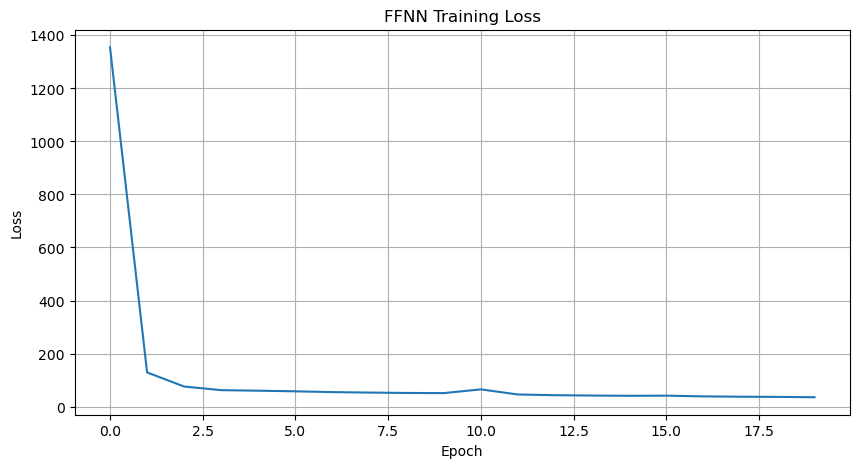

Episode 80/100: Evaluating FFNN
Episode 80/100 | Reward: -1761.5769
Train MSE: 36.8763 | Train Female MSE: 10.5623
Val MSE: 324.5858 | Val Female MSE: 105.2098
Test MSE: 68.2533 | Test Female MSE: 11.4793

--------------------------------

Episode 81/100: Generating Synthetic Data
Episode 81/100: Training FFNN


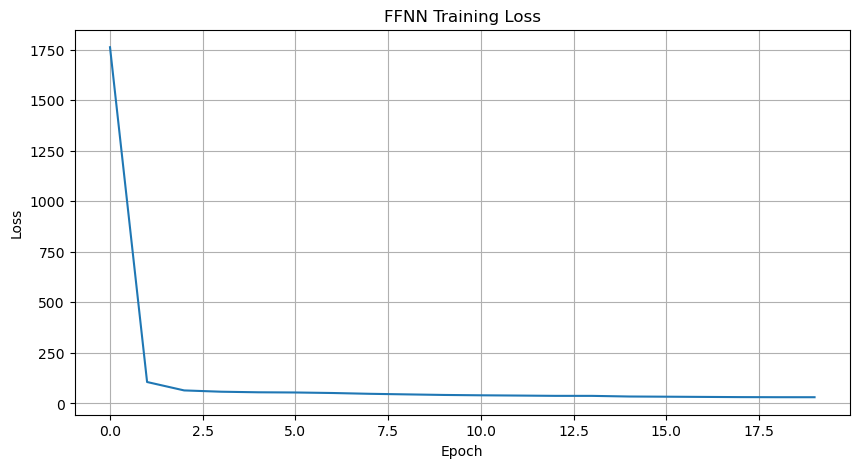

Episode 81/100: Evaluating FFNN
Episode 81/100 | Reward: -3004.7490
Train MSE: 32.1447 | Train Female MSE: 11.0549
Val MSE: 440.0551 | Val Female MSE: 156.9470
Test MSE: 75.4890 | Test Female MSE: 21.6644

--------------------------------

Episode 82/100: Generating Synthetic Data
Episode 82/100: Training FFNN


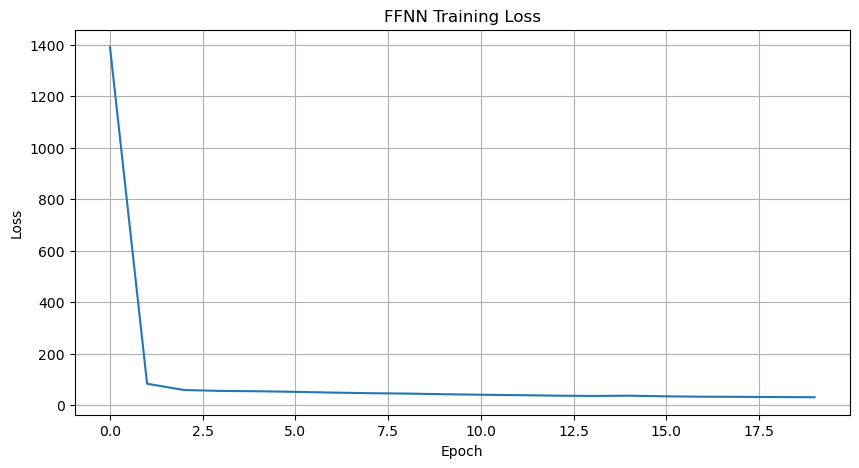

Episode 82/100: Evaluating FFNN
Episode 82/100 | Reward: -859.6656
Train MSE: 30.0267 | Train Female MSE: 5.6669
Val MSE: 219.8041 | Val Female MSE: 31.6648
Test MSE: 42.1445 | Test Female MSE: 11.8108

--------------------------------

Episode 83/100: Generating Synthetic Data
Episode 83/100: Training FFNN


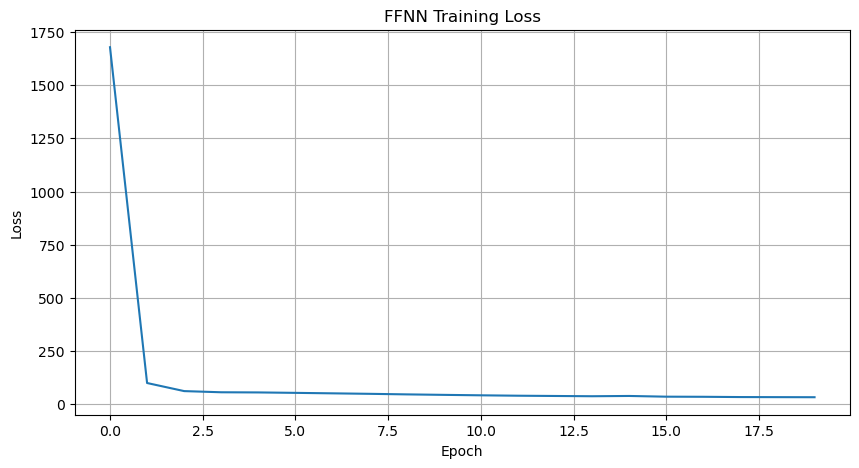

Episode 83/100: Evaluating FFNN
Episode 83/100 | Reward: -241.7795
Train MSE: 31.6080 | Train Female MSE: 7.9089
Val MSE: 165.0997 | Val Female MSE: 73.6682
Test MSE: 48.5688 | Test Female MSE: 9.1081

--------------------------------

Episode 84/100: Generating Synthetic Data
Episode 84/100: Training FFNN


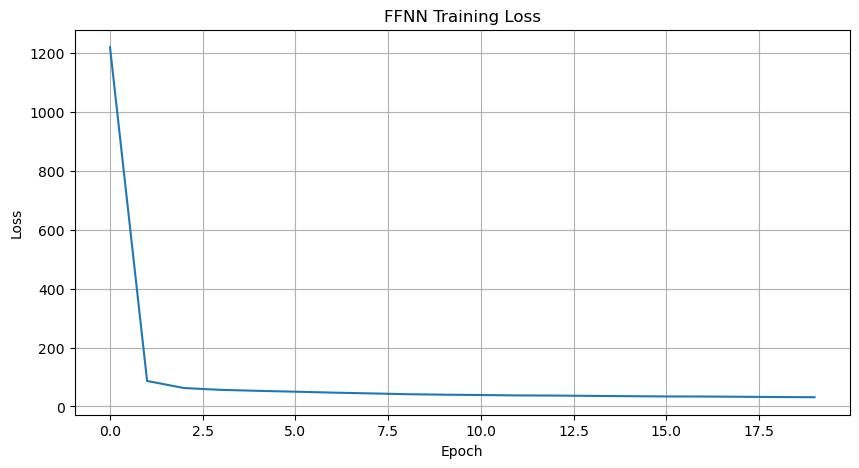

Episode 84/100: Evaluating FFNN
Episode 84/100 | Reward: -481.6636
Train MSE: 32.4686 | Train Female MSE: 5.8895
Val MSE: 189.2147 | Val Female MSE: 17.0803
Test MSE: 68.7292 | Test Female MSE: 3.1708

--------------------------------

Episode 85/100: Generating Synthetic Data
Episode 85/100: Training FFNN


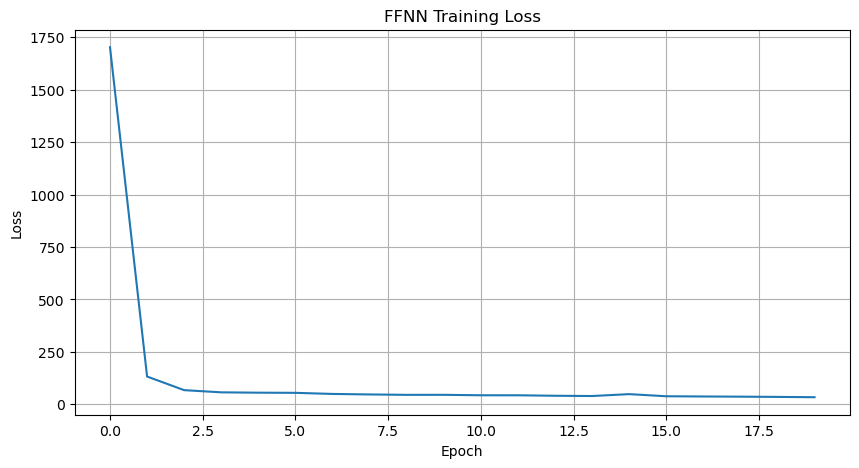

Episode 85/100: Evaluating FFNN
Episode 85/100 | Reward: -126.5910
Train MSE: 33.7866 | Train Female MSE: 5.7928
Val MSE: 149.8986 | Val Female MSE: 28.2718
Test MSE: 53.2591 | Test Female MSE: 4.0162

--------------------------------

Episode 86/100: Generating Synthetic Data
Episode 86/100: Training FFNN


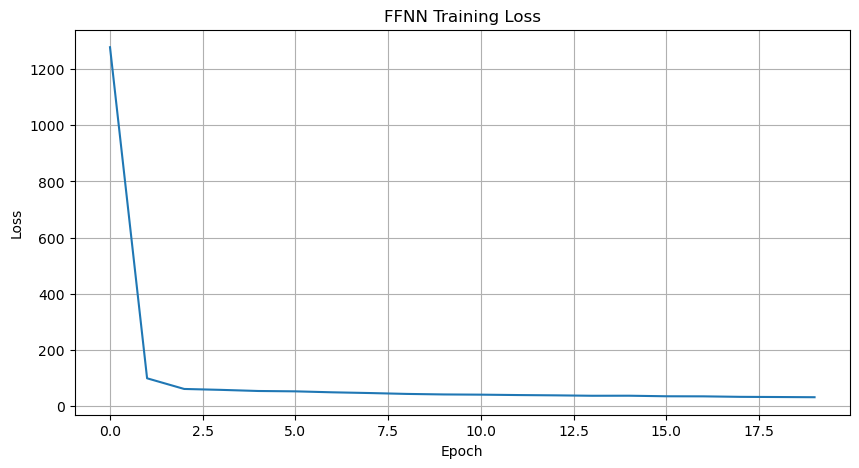

Episode 86/100: Evaluating FFNN
Episode 86/100 | Reward: -540.4540
Train MSE: 30.0606 | Train Female MSE: 7.9917
Val MSE: 179.6247 | Val Female MSE: 54.1619
Test MSE: 51.8362 | Test Female MSE: 9.3044

--------------------------------

Episode 87/100: Generating Synthetic Data
Episode 87/100: Training FFNN


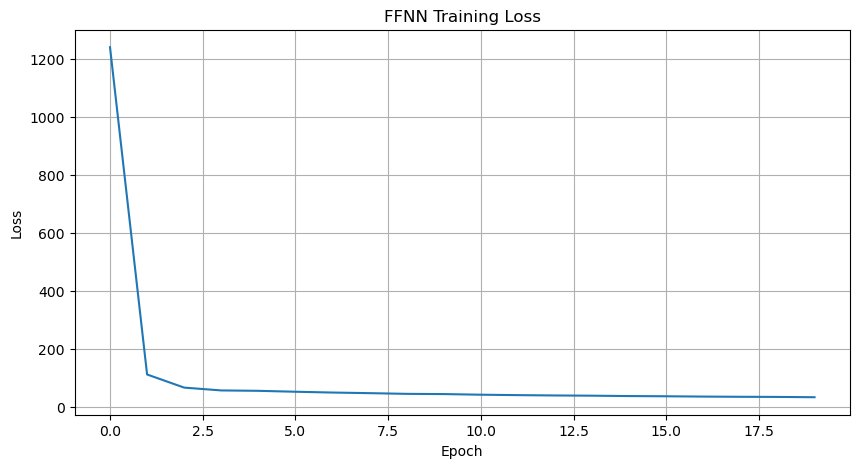

Episode 87/100: Evaluating FFNN
Episode 87/100 | Reward: -442.9183
Train MSE: 34.3537 | Train Female MSE: 8.4414
Val MSE: 161.9571 | Val Female MSE: 35.0594
Test MSE: 66.5386 | Test Female MSE: 8.1753

--------------------------------

Episode 88/100: Generating Synthetic Data
Episode 88/100: Training FFNN


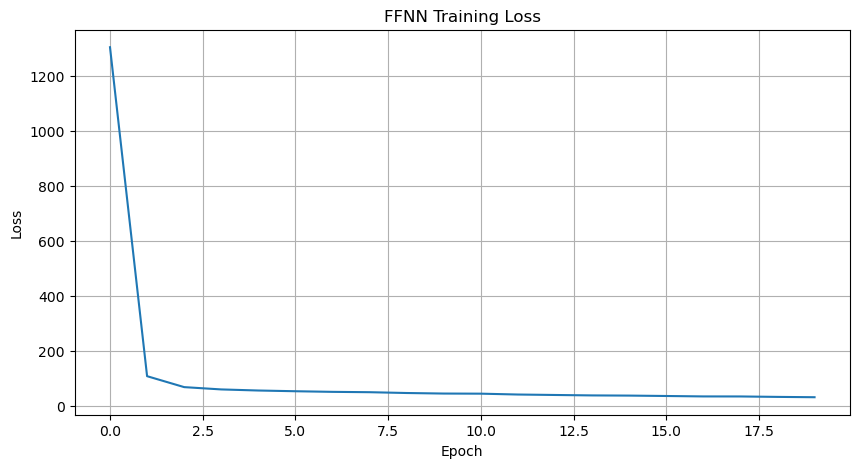

Episode 88/100: Evaluating FFNN
Episode 88/100 | Reward: -60.3259
Train MSE: 32.1437 | Train Female MSE: 7.6691
Val MSE: 116.9603 | Val Female MSE: 28.7853
Test MSE: 56.2169 | Test Female MSE: 7.0028

--------------------------------

Episode 89/100: Generating Synthetic Data
Episode 89/100: Training FFNN


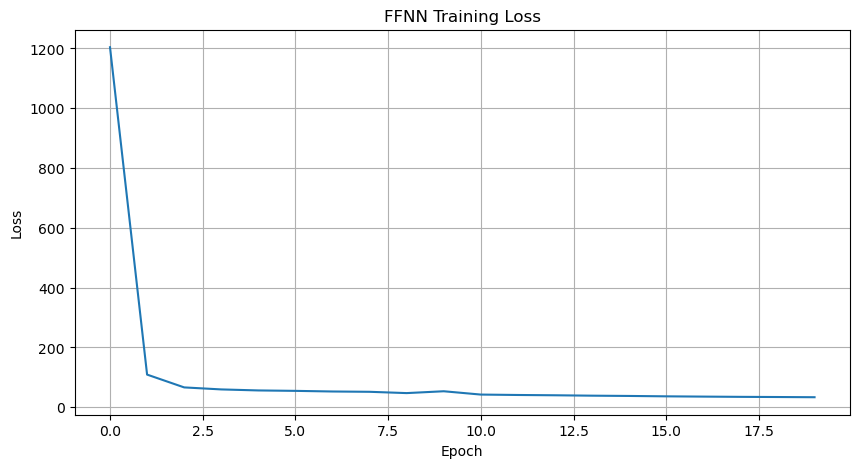

Episode 89/100: Evaluating FFNN
Episode 89/100 | Reward: -990.8143
Train MSE: 34.2881 | Train Female MSE: 9.6488
Val MSE: 209.5009 | Val Female MSE: 69.3454
Test MSE: 86.4779 | Test Female MSE: 8.2781

--------------------------------

Episode 90/100: Generating Synthetic Data
Episode 90/100: Training FFNN


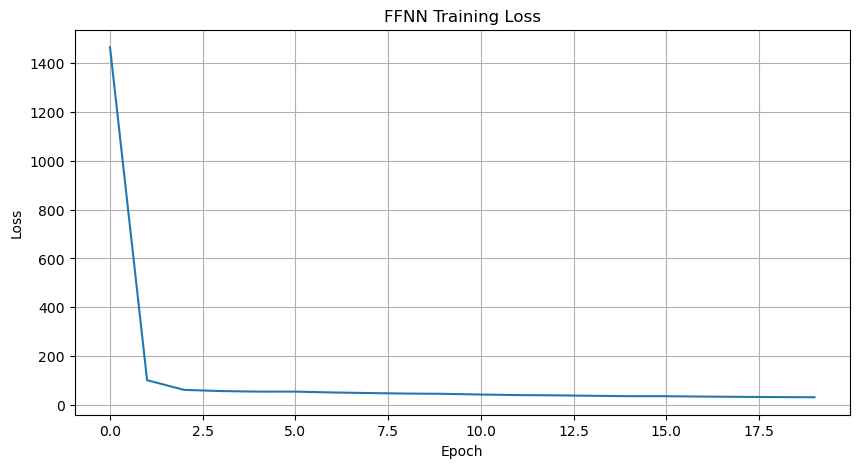

Episode 90/100: Evaluating FFNN
Episode 90/100 | Reward: -1079.5206
Train MSE: 31.4961 | Train Female MSE: 6.5413
Val MSE: 228.2486 | Val Female MSE: 80.9486
Test MSE: 62.4179 | Test Female MSE: 25.4025

--------------------------------

Episode 91/100: Generating Synthetic Data
Episode 91/100: Training FFNN


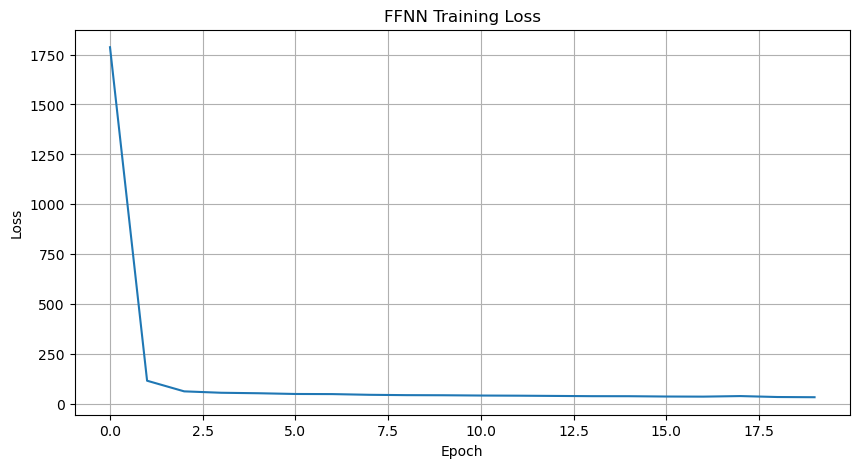

Episode 91/100: Evaluating FFNN
Episode 91/100 | Reward: 235.5411
Train MSE: 32.9964 | Train Female MSE: 6.6638
Val MSE: 97.0968 | Val Female MSE: 11.9246
Test MSE: 57.7199 | Test Female MSE: 2.7031

--------------------------------

Episode 92/100: Generating Synthetic Data
Episode 92/100: Training FFNN


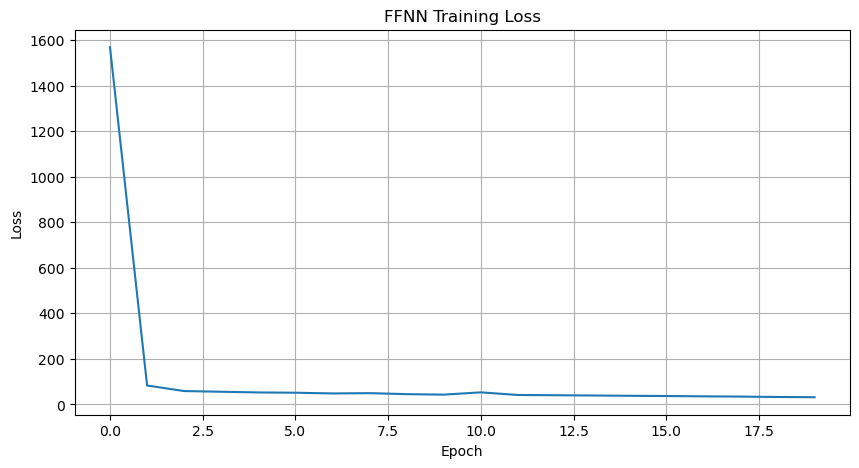

Episode 92/100: Evaluating FFNN
Episode 92/100 | Reward: -1901.7944
Train MSE: 30.1562 | Train Female MSE: 5.5951
Val MSE: 317.7402 | Val Female MSE: 54.4346
Test MSE: 51.7474 | Test Female MSE: 8.3357

--------------------------------

Episode 93/100: Generating Synthetic Data
Episode 93/100: Training FFNN


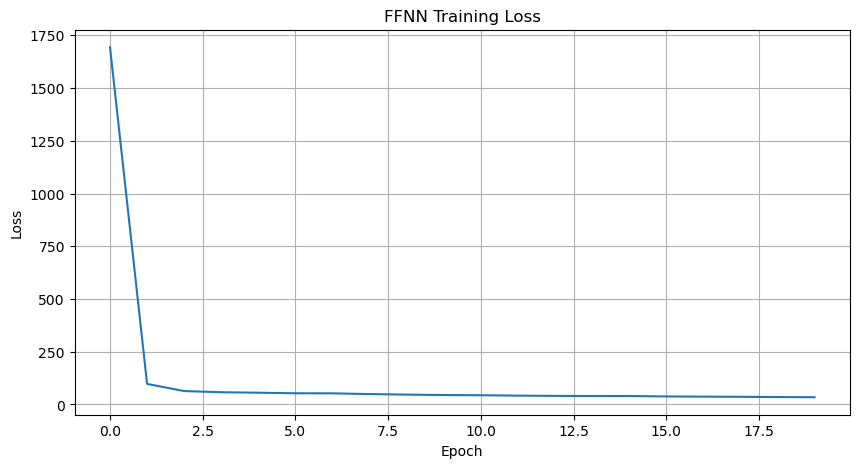

Episode 93/100: Evaluating FFNN
Episode 93/100 | Reward: -530.3177
Train MSE: 33.9099 | Train Female MSE: 8.5536
Val MSE: 206.0538 | Val Female MSE: 66.5370
Test MSE: 71.6693 | Test Female MSE: 13.6187

--------------------------------

Episode 94/100: Generating Synthetic Data
Episode 94/100: Training FFNN


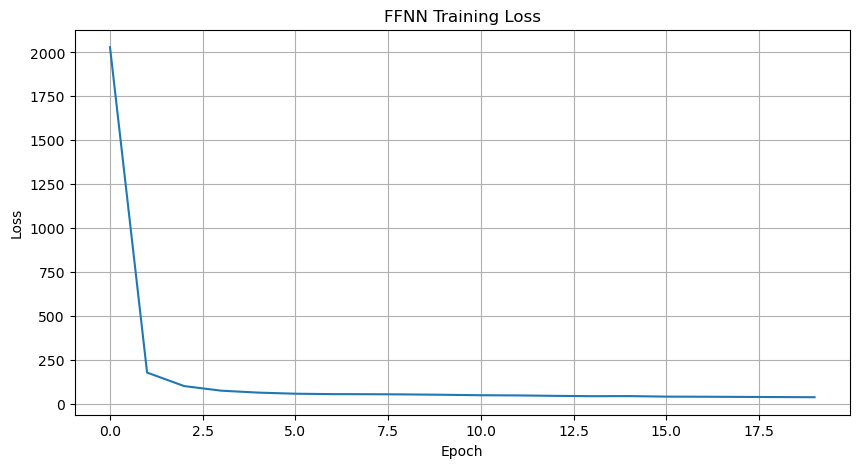

Episode 94/100: Evaluating FFNN
Episode 94/100 | Reward: -232.6753
Train MSE: 41.0208 | Train Female MSE: 10.3657
Val MSE: 182.7559 | Val Female MSE: 29.2699
Test MSE: 59.4035 | Test Female MSE: 6.3893

--------------------------------

Episode 95/100: Generating Synthetic Data
Episode 95/100: Training FFNN


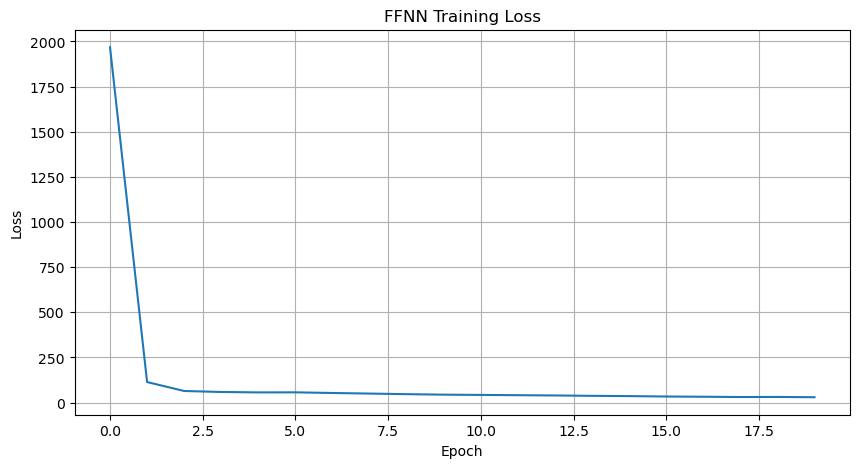

Episode 95/100: Evaluating FFNN
Episode 95/100 | Reward: -5366.2495
Train MSE: 29.1773 | Train Female MSE: 7.0372
Val MSE: 701.0169 | Val Female MSE: 47.1675
Test MSE: 79.8345 | Test Female MSE: 48.4077

--------------------------------

Episode 96/100: Generating Synthetic Data
Episode 96/100: Training FFNN


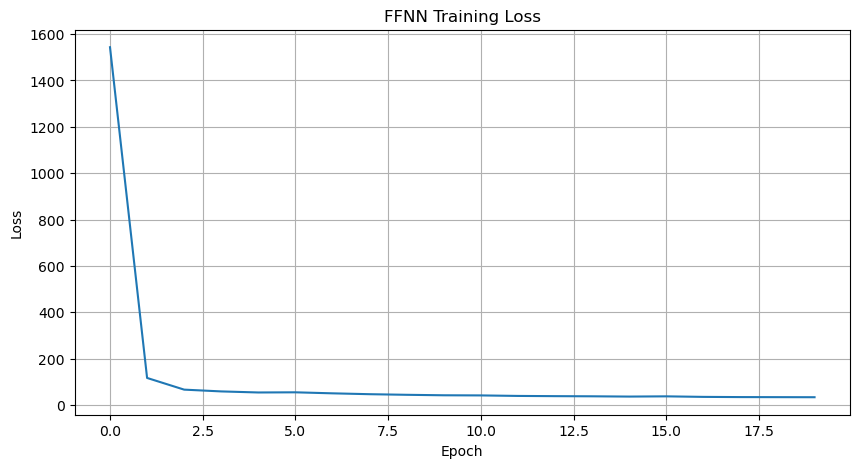

Episode 96/100: Evaluating FFNN
Episode 96/100 | Reward: -743.8972
Train MSE: 40.6809 | Train Female MSE: 16.9208
Val MSE: 255.2463 | Val Female MSE: 86.3976
Test MSE: 116.7566 | Test Female MSE: 22.5364

--------------------------------

Episode 97/100: Generating Synthetic Data
Episode 97/100: Training FFNN


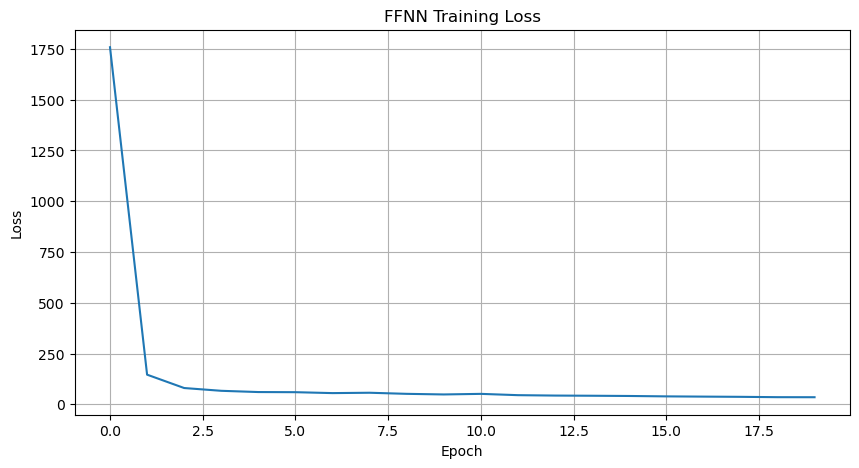

Episode 97/100: Evaluating FFNN
Episode 97/100 | Reward: -749.1820
Train MSE: 34.0958 | Train Female MSE: 6.2105
Val MSE: 246.0097 | Val Female MSE: 48.0013
Test MSE: 60.6513 | Test Female MSE: 4.3156

--------------------------------

Episode 98/100: Generating Synthetic Data
Episode 98/100: Training FFNN


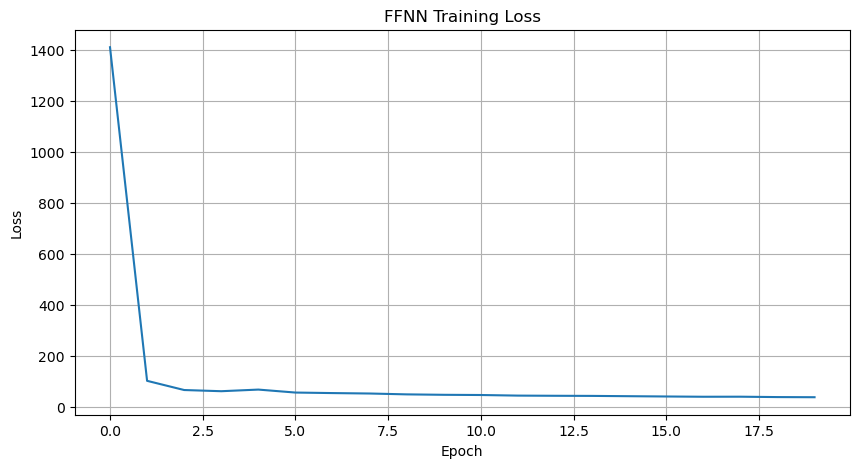

Episode 98/100: Evaluating FFNN
Episode 98/100 | Reward: -2953.1120
Train MSE: 36.0355 | Train Female MSE: 7.2913
Val MSE: 459.8879 | Val Female MSE: 111.5885
Test MSE: 57.9122 | Test Female MSE: 3.2618

--------------------------------

Episode 99/100: Generating Synthetic Data
Episode 99/100: Training FFNN


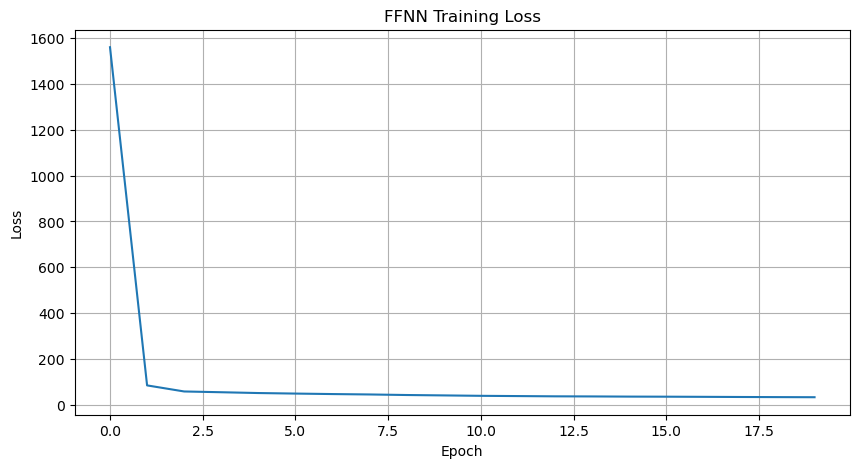

Episode 99/100: Evaluating FFNN
Episode 99/100 | Reward: -2597.3897
Train MSE: 34.4203 | Train Female MSE: 6.8773
Val MSE: 408.0905 | Val Female MSE: 61.8223
Test MSE: 87.0691 | Test Female MSE: 7.1492

--------------------------------

Episode 100/100: Generating Synthetic Data
Episode 100/100: Training FFNN


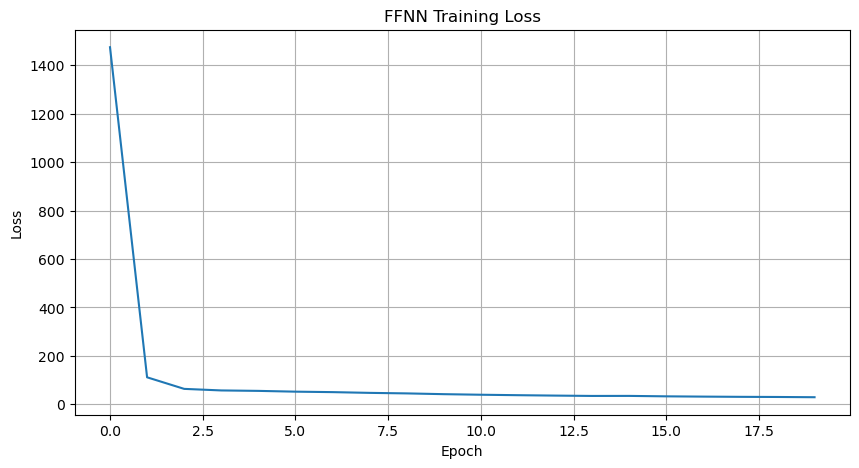

Episode 100/100: Evaluating FFNN
Episode 100/100 | Reward: -626.1433
Train MSE: 27.9863 | Train Female MSE: 4.5611
Val MSE: 194.7740 | Val Female MSE: 58.6466
Test MSE: 38.3412 | Test Female MSE: 1.7615

--------------------------------

Metrics saved to training_metrics_nadine.json
Model saved to dqn_trained_model_nadine.pth
Model saved to ppo_trained_model_nadine.pth


In [4]:
def evaluate_ffnn(ffnn_agent, data, labels):
    if isinstance(data, (pd.DataFrame, pd.Series)):
        data = data.to_numpy()
    if isinstance(labels, (pd.DataFrame, pd.Series)):
        labels = labels.to_numpy()

    predictions = ffnn_agent.predict(data)

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()

    mse = mean_squared_error(labels, predictions)
    mae = mean_absolute_error(labels, predictions)

    # Optional: female-specific evaluation
    female_mask = data[:, -1] == 1
    if female_mask.sum() > 0:
        female_preds = predictions[female_mask]
        female_labels = labels[female_mask]
        female_mse = mean_squared_error(female_labels, female_preds)
    else:
        female_mse = float('nan')

    return mse, mae, female_mse



def plot_ffnn_losses(losses):
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('FFNN Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    # ages in df = [27, 25, 31, 24, 26, 23]

def generate_state(df, mf_ratio, n_samples):
    timestamp = np.random.uniform(df['Timestamp'].min(), df['Timestamp'].max())
    male_female_ratio = mf_ratio 
    num_samples = n_samples
    age = np.random.uniform(24, 31)
    activity_id = np.random.choice([1, 2])
    return np.array([timestamp, male_female_ratio, num_samples, age, activity_id])


def compute_mini_reward(synthetic_data, mf_ratio):
    column_std = np.std(synthetic_data, axis=0).mean()
    gaussian_penalty = np.exp(-((mf_ratio - 0.5) ** 2) / 0.1)
    return column_std + gaussian_penalty


def train_ffnn_baseline(ffnn_agent, x_train, y_train, x_val, y_val, x_test, y_test):
    # Train on real data only
    print("\nTraining FFNN on real data only (no synthetic data)...")
    losses = ffnn_agent.train(x_train.to_numpy(), y_train.to_numpy())
    plot_ffnn_losses(losses)

    # Evaluate on all splits
    train_mse, train_mae, train_female_mse = evaluate_ffnn(ffnn_agent, x_train, y_train)
    val_mse, val_mae, val_female_mse = evaluate_ffnn(ffnn_agent, x_val, y_val)
    test_mse, test_mae, test_female_mse = evaluate_ffnn(ffnn_agent, x_test, y_test)

    # Print results
    print("\n========== FFNN Baseline (No Synthetic Data) ==========")
    print(f"Train MSE: {train_mse:.4f} | Train MAE: {train_mae:.4f} | Female MSE: {train_female_mse:.4f}")
    print(f"Val   MSE: {val_mse:.4f} | Val   MAE: {val_mae:.4f} | Female MSE: {val_female_mse:.4f}")
    print(f"Test  MSE: {test_mse:.4f} | Test  MAE: {test_mae:.4f} | Female MSE: {test_female_mse:.4f}")
    print("=======================================================\n")

    return {
        "train": (train_mse, train_mae),
        "val": (val_mse, val_mae),
        "test": (test_mse, test_mae),
    }

baseline_results = train_ffnn_baseline(ffnn_agent_og, x_train, y_train, x_val, y_val, x_test, y_test)

def train_agents(x_train, y_train, x_val, y_val, x_test, y_test,
                 dqn_agent, ppo_agent, ffnn_agent, episodes=num_episodes,
                 save_path='training_metrics_nadine.json'):

    # Normalize y arrays to shape (n, 1)
    # for var in ['y_train', 'y_val', 'y_test']:
    #     val = locals()[var]
    #     if isinstance(val, pd.Series):
    #         locals()[var] = val.to_numpy().reshape(-1, 1)
    #     elif isinstance(val, pd.DataFrame):
    #         locals()[var] = val.to_numpy()

    rewards = []
    val_accuracies = []
    test_accuracies = []
    train_accuracies = []
    val_female_accuracies = []
    test_female_accuracies = []
    train_female_accuracies = []

    synthetic_data = []
    synthetic_labels = []

    # Initial male-female ratio
    sex_female_idx = x_train.columns.get_loc('Sex - Female')
    mf_ratio = np.mean(x_train.iloc[:, sex_female_idx])
    state = generate_state(x_train, mf_ratio, 0)






    for episode in range(episodes):
        print(f"Episode {episode + 1}/{episodes}: Generating Synthetic Data")
        for i in range(synthetic_data_amount):
            if synthetic_data:
                synthetic_array = np.array(synthetic_data)
                if synthetic_array.ndim == 1:
                    synthetic_array = synthetic_array.reshape(1, -1)
                combined_array = np.vstack([x_train.to_numpy(), synthetic_array])
                combined = pd.DataFrame(combined_array, columns=x_train.columns)
            else:
                combined = x_train.copy()

            sex_female_idx = combined.columns.get_loc('Sex - Female')
            mf_ratio = np.mean(combined.iloc[:, sex_female_idx])

            # Predict actions from RL agents
            discrete_action = np.array(dqn_agent.predict(state), ndmin=1).flatten()

            # First 2 values are features: 'Sex - Female', 'Heart Rate'
            sex_value = discrete_action[0]
            heart_rate = discrete_action[1]

            # Predicted target values: Resting HR, Max HR, Weight, Height (4 values)
            predicted_targets = discrete_action[2:6]

            # Age comes from the state (4th element)
            age_from_state = state[3]

            # Combine into full target: [Resting HR, Max HR, Age, Weight, Height]
            target_values = np.insert(predicted_targets, 2, age_from_state)  # insert age at index 2
            # Resulting shape: (5,) — matches label format

            # Predict continuous features
            continuous_action = np.array(ppo_agent.predict(state), ndmin=1)  # shape (1, num_continuous_features)

            # Create synthetic feature row
            synthetic_row = np.zeros(x_train.shape[1])

            # Get column indices
            discrete_indices = x_train.columns.get_indexer(['Sex - Female', 'Heart Rate'])
            continuous_indices = x_train.columns.get_indexer(continuous_columns)

            # Assign values to synthetic row
            synthetic_row[discrete_indices[0]] = sex_value
            synthetic_row[discrete_indices[1]] = heart_rate
            synthetic_row[continuous_indices] = continuous_action.flatten()

            # Add to synthetic dataset
            synthetic_data.append(synthetic_row)
            synthetic_labels.append(target_values)

            mini_reward = compute_mini_reward(np.array(synthetic_data), mf_ratio)
            done = i == synthetic_data_amount - 1


            if done:
                print(f"Episode {episode + 1}/{episodes}: Training FFNN")
                
                ffnn_agent.reset()

                synthetic_data_np = np.array(synthetic_data)                    # (n_samples, num_features)
                synthetic_labels_np = np.array(synthetic_labels).reshape(-1, 5) # (n_samples, 5)

                combined_data = np.vstack([x_train.to_numpy(), synthetic_data_np])
                combined_labels = np.vstack([y_train, synthetic_labels_np])


                # Shuffle combined training data
                indices = np.arange(combined_data.shape[0])
                np.random.shuffle(indices)
                combined_data = combined_data[indices]
                combined_labels = combined_labels[indices]

                # Train FFNN
                losses = ffnn_agent.train(combined_data, combined_labels)
                plot_ffnn_losses(losses)

                print(f"Episode {episode + 1}/{episodes}: Evaluating FFNN")

                train_mse, train_mae, train_female_mse = evaluate_ffnn(ffnn_agent, x_train, y_train)
                val_mse, val_mae, val_female_mse = evaluate_ffnn(ffnn_agent, x_val, y_val)
                test_mse, test_mae, test_female_mse = evaluate_ffnn(ffnn_agent, x_test, y_test)

                # Reward is based on validation performance and mini reward
                reward = (accuracy_reward_multiplier * val_mse * -1) + (mini_reward)

                train_accuracies.append(train_mse)
                val_accuracies.append(val_mse)
                test_accuracies.append(test_mse)
                train_female_accuracies.append(train_female_mse)
                val_female_accuracies.append(val_female_mse)
                test_female_accuracies.append(test_female_mse)

                print(f"Episode {episode + 1}/{episodes} | Reward: {reward:.4f}")
                print(f"Train MSE: {train_mse:.4f} | Train Female MSE: {train_female_mse:.4f}")
                print(f"Val MSE: {val_mse:.4f} | Val Female MSE: {val_female_mse:.4f}")
                print(f"Test MSE: {test_mse:.4f} | Test Female MSE: {test_female_mse:.4f}")
                print("\n--------------------------------\n")


                synthetic_data = []
                synthetic_labels = []
            else:
                reward = mini_reward

            next_state = generate_state(x_train, mf_ratio, len(synthetic_data) + 1)
            dqn_agent.learn(state, discrete_action, reward, next_state, done)
            ppo_agent.learn(state, continuous_action, reward, next_state, done)

            rewards.append(reward)
            state = next_state

        metrics = {
            'rewards': rewards,
            'train_mse': train_accuracies,
            'val_mse': val_accuracies,
            'test_mse': test_accuracies,
            'train_female_mse': train_female_accuracies,
            'val_female_mse': val_female_accuracies,
            'test_female_mse': test_female_accuracies
        }


    with open(save_path, 'w') as f:
        json.dump(metrics, f)
    print(f"Metrics saved to {save_path}")

    return metrics

# Example usage
results = train_agents(x_train, y_train, x_val, y_val, x_test, y_test, dqn_agent, ppo_agent, ffnn_agent)
dqn_agent.save("dqn_trained_model_nadine.pth")
ppo_agent.save("ppo_trained_model_nadine.pth")


# Testing


In [5]:
mse, mae, female_mse = evaluate_ffnn(ffnn_agent, x_test, y_test)
print(f"Test Results | MSE: {mse} | MAE: {mae} | Female MSE: {female_mse}")

Test Results | MSE: 38.34119415283203 | MAE: 4.644286632537842 | Female MSE: 1.7615371942520142


# Visualize results

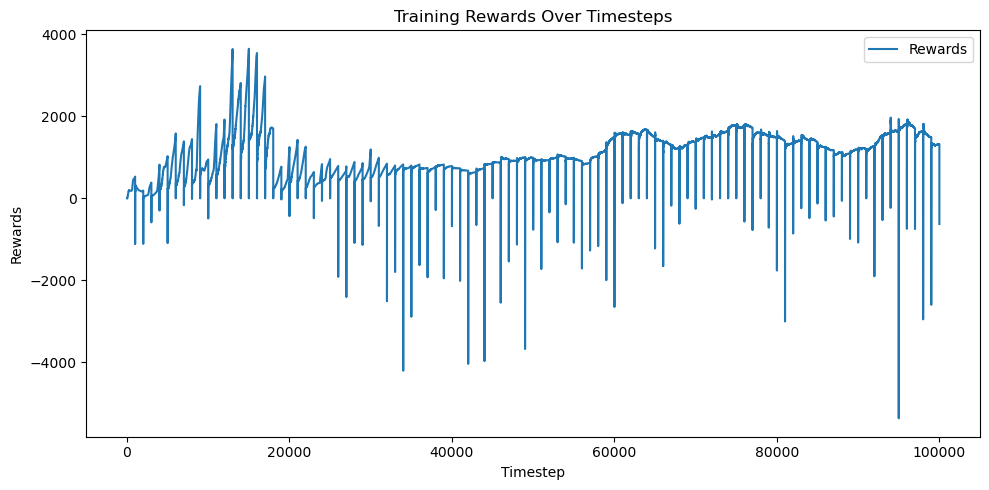

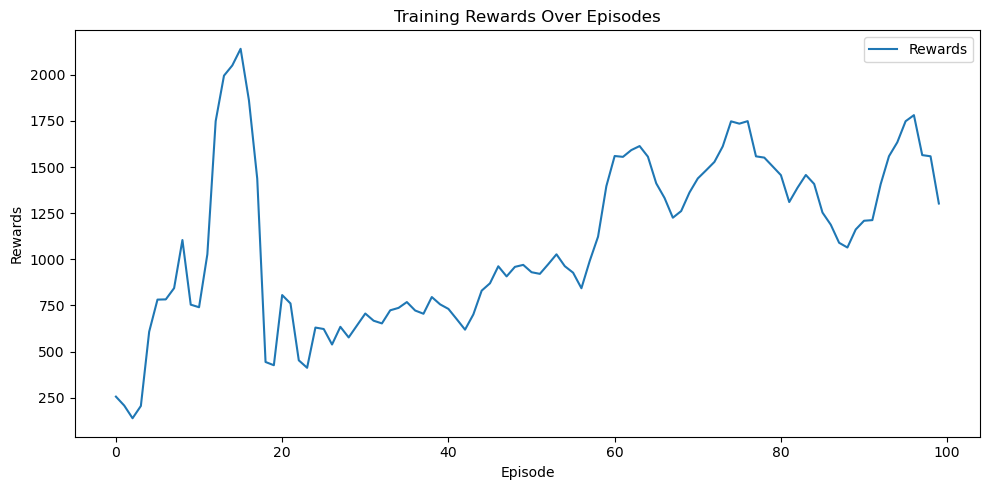

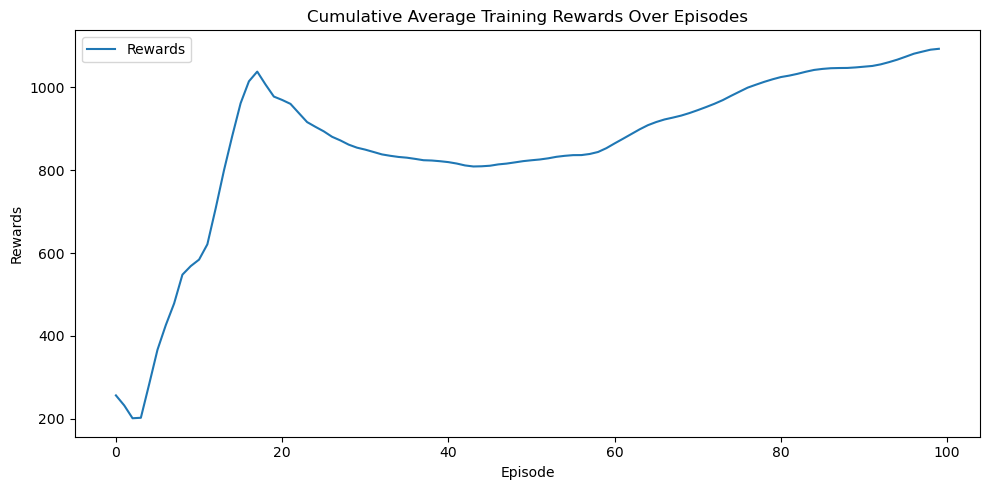

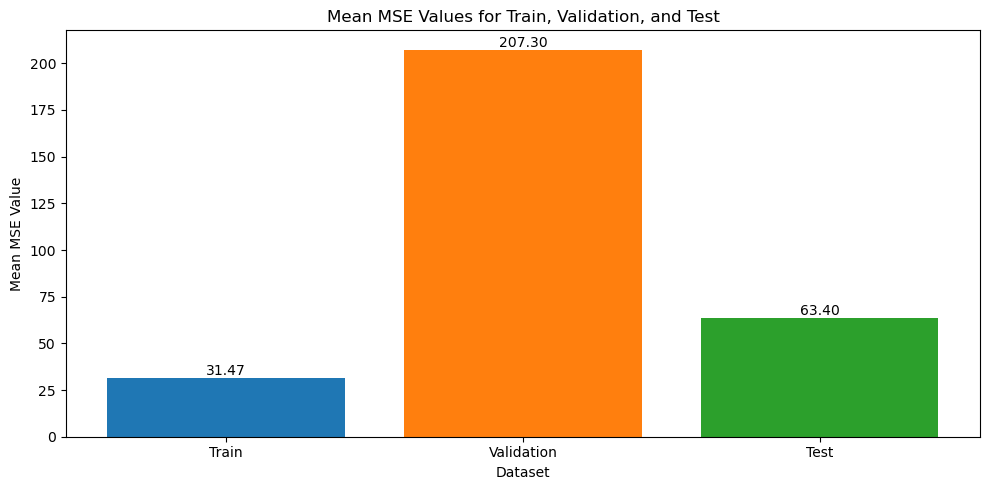

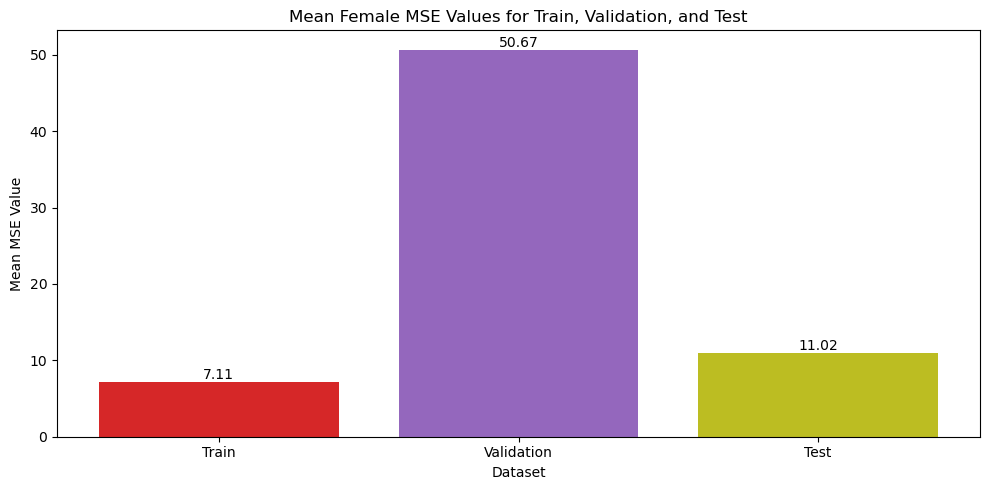

In [6]:
from visualize import *

# plot_baseline_mse_histogram(baseline_results)
plot_rewards(save_path='training_metrics.json')
plot_rewards_per_episode(save_path='training_metrics.json')
plot_rewards_cum_avg(save_path='training_metrics.json')
plot_mse_histogram(save_path='training_metrics.json')
plot_female_mse_histogram(save_path='training_metrics.json')
